# Introduction
Today, it is widely acknowledged that the risk of re-identification using data pseudonymization methods is significant, presenting a considerable challenge, particularly in the context of personal health data. The high risk of re-identification poses a serious threat to individuals' privacy and can lead to severe consequences. Patients entrust their personal health information to healthcare institutions with the expectation that it will be safeguarded and used responsibly. However, if these data can be re-identified, it represents a breach of that trust. Nonetheless, value is also created by re-analyzing, sharing, and eventually licensing out data. The challenge here is to generate synthetic data that preserves the patient's privacy and retains the statistical value of the dataset. We are going to generate synthetic data using the “Avatar” method, introduced by Guillaudeux et al. in the publication that you can find here: https://www.nature.com/articles/s41746-023-00771-5. The Avatar method is patient-centric (i.e., it uses the characteristics of a single patient as the starting point of its statistical modeling). Even though each individual is at the origin of the creation of their avatar simulation, they do not directly contribute to the local modeling of their Avatar generation, which I believe is a very clever way to generate synthetic data that will meet the conditions mentioned above.



In [73]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [74]:
df = pd.read_csv("/content/dataPT2.csv",sep = ";",decimal=',')

In [75]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

In [76]:
df

encounter_id  patient_id  hospital_id   age        bmi  \
0            113303       63835          185  77.0  26.822874   
1            100799       68271            6  19.0  22.890904   
2             97702       25893           77  49.0  33.855754   
3             66955        4599           19  52.0  36.358025   
4             90681        1541          132  83.0  29.277836   
...             ...         ...          ...   ...        ...   
82537         26716        6791           55  54.0  29.357335   
82538         10009       33376          174  50.0  23.021962   
82539          8410      110955           62   NaN  19.333766   
82540        112003       96590          118  75.0  18.906551   
82541         69087       71222           15  76.0  43.621516   

       elective_surgery         ethnicity gender  height  \
0                     0  African American      M   172.7   
1                     0             Asian      M   167.6   
2                     0         Caucasian      F   167.6   
3                     0  African American      F   180.0   
4                     0         Caucasian      F   152.4   
...                 ...               ...    ...     ...   
82537                 1     Other/Unknown      M   182.8   
82538                 0         Caucasian      M   180.3   
82539                 0         Caucasian      F   165.1   
82540                 0         Caucasian      M   175.3   
82541                 0         Caucasian      M   177.8   

                icu_admit_source  icu_id icu_stay_type      icu_type  \
0           Accident & Emergency     711         admit     CCU-CTICU   
1           Accident & Emergency     915         admit  Med-Surg ICU   
2           Accident & Emergency     113         admit  Med-Surg ICU   
3           Accident & Emergency     657         admit     CCU-CTICU   
4           Accident & Emergency     499         admit  Med-Surg ICU   
...                          ...     ...           ...           ...   
82537  Operating Room / Recovery     391         admit         CSICU   
82538       Accident & Emergency     212         admit   Cardiac ICU   
82539                      Floor     477         admit   Cardiac ICU   
82540                      Floor     114         admit     CCU-CTICU   
82541       Accident & Emergency     878         admit  Med-Surg ICU   

       pre_icu_los_days  weight  apache_2_diagnosis  apache_3j_diagnosis  \
0              0.197222   80.00               109.0               108.01   
1              0.426389   64.30               122.0               703.03   
2              0.002778   95.10               122.0               703.03   
3              0.152778  117.80               112.0               107.01   
4              0.050000   68.00               115.0               101.01   
...                 ...     ...                 ...                  ...   
82537          1.213194   98.10               308.0              1207.01   
82538          0.093056   74.84               123.0               702.01   
82539          2.982639   52.70               302.0               111.01   
82540          0.358333   58.10               112.0               107.01   
82541          0.004167  137.90               305.0               901.03   

       apache_post_operative  arf_apache  gcs_eyes_apache  gcs_motor_apache  \
0                          0         0.0              4.0               6.0   
1                          0         0.0              4.0               5.0   
2                          0         0.0              4.0               6.0   
3                          0         0.0              4.0               6.0   
4                          0         0.0              4.0               6.0   
...                      ...         ...              ...               ...   
82537                      1         0.0              2.0               5.0   
82538                      0         0.0              4.0               6.0   
82539           

# Pseudonymisation before anonymization.
In order to apply the "Avatar " method the data must be pseudonymised.


In [77]:
new_encounter_IDs = np.arange(1000, 1000 + len(df))
df['encounter_id'] =new_encounter_IDs

# EDA

In [78]:
# Checking the missing values

df.isnull().sum()

encounter_id                        0
patient_id                          0
hospital_id                         0
age                              3831
bmi                              3089
elective_surgery                    0
ethnicity                        1241
gender                             23
height                           1213
icu_admit_source                  102
icu_id                              0
icu_stay_type                       0
icu_type                            0
pre_icu_los_days                    0
weight                           2451
apache_2_diagnosis               1488
apache_3j_diagnosis               992
apache_post_operative               0
arf_apache                        649
gcs_eyes_apache                  1712
gcs_motor_apache                 1712
gcs_unable_apache                 936
gcs_verbal_apache                1712
heart_rate_apache                 793
intubated_apache                  649
map_apache                        896
resprate_apa

In [79]:
#Cheking the types of the variable

df.dtypes.value_counts()

float64    70
int64       7
object      7
Name: count, dtype: int64

In [80]:
colonne_64 = df.select_dtypes(include = "float64")

In [81]:
columns_to_delete = [ "patient_id","hospital_id","elective_surgery","ethnicity","gender",
                  "icu_admit_source","icu_id","icu_stay_type","icu_type","apache_post_operative",
                  "arf_apache","gcs_eyes_apache","gcs_motor_apache","gcs_unable_apache","gcs_verbal_apache",
                  "intubated_apache","ventilated_apache",
                  "apache_4a_icu_death_prob","aids","cirrhosis","diabetes_mellitus","hepatic_failure","immunosuppression",
                  "leukemia","lymphoma",
                  "solid_tumor_with_metastasis","apache_3j_bodysystem",
                   "apache_2_bodysystem","hospital_death"]


In [82]:
#Deleting the qualitatives variables in order to do the pca

df.drop(columns = columns_to_delete,inplace= True)


In [83]:
# Imputing the missing values

Imputer = SimpleImputer(strategy = "median")
df_imputed = pd.DataFrame(Imputer.fit_transform(df),columns= df.columns)

# Generating the Synthetic values using "Avatar" method :

Individual observations are projected into a multidimensional space using factor analysis techniques; in our case, we use PCA. Using the first 'nd' dimensions of this space, pairwise distances are computed between each sensitive individual observation to find the 'k' nearest neighbors with the KNN algorithm, which defines a local area. For each individual, a single avatar simulation is pseudo-stochastically drawn in its local area.

Considering an individual 'O' in the original dataset 'D', the aim is to create an avatar simulation 'A' for each 'O'. Once the 'k' neighbors of 'O' are identified, a random weight is assigned to each neighbor. These 'k' weights are defined as follows:

for i in [1, ..., k]: P_i = D_i × R_i × C_i

where:

D_i is the inverse of the distance between 'O' and its ith neighbor 'k',
R_i ~ ξ(1): a random weight following an exponential distribution with λ = 1,
C_i: a contribution, where 'j' is the value at the ith index of the randomly shuffled vector [1, 2,…, k].
Each of the 'k' nearest neighbors of the individual 'O' yields a weight 'W_k' between 0 and 1. Avatar simulation coordinates are then generated at the weighted center of the 'k' nearest neighbors.

In [84]:
# We center and reduce the data in order to apply the PCA
Scaler = StandardScaler()
scaled_data = Scaler.fit_transform(df_imputed)
# Applying the pca
pca = PCA()
X_pca = pca.fit_transform(scaled_data)


In [85]:
# Checking the variance in each variable

comp = pd.DataFrame(
    {"dimension" : ["dim"+ str(x+1) for x in range (55)],
     "valeur_propre" : pca.explained_variance_,
     "% variance expliquée" : np.round(pca.explained_variance_ratio_*100),
     "% cum. var. expliquée": np.round(np.cumsum(pca.explained_variance_ratio_)*100)
    },
    columns = ["dimension","valeur_propre","% variance expliquée","% cum. var. expliquée"]
)
comp


dimension  valeur_propre  % variance expliquée  % cum. var. expliquée
0       dim1      13.385314                  24.0                   24.0
1       dim2       5.258592                  10.0                   34.0
2       dim3       4.296086                   8.0                   42.0
3       dim4       2.508172                   5.0                   46.0
4       dim5       2.211488                   4.0                   50.0
5       dim6       2.081058                   4.0                   54.0
6       dim7       1.876180                   3.0                   57.0
7       dim8       1.820504                   3.0                   61.0
8       dim9       1.686586                   3.0                   64.0
9      dim10       1.531339                   3.0                   67.0
10     dim11       1.434034                   3.0                   69.0
11     dim12       1.184333                   2.0                   71.0
12     dim13       1.103316                   2.0                   73.0
13     dim14       1.065750                   2.0                   75.0
14     dim15       1.009432                   2.0                   77.0
15     dim16       0.998055                   2.0                   79.0
16     dim17       0.945460                   2.0                   81.0
17     dim18       0.871445                   2.0                   82.0
18     dim19       0.838301                   2.0                   84.0
19     dim20       0.764980                   1.0                   85.0
20     dim21       0.683170                   1.0                   86.0
21     dim22       0.618862                   1.0                   88.0
22     dim23       0.616974                   1.0                   89.0
23     dim24       0.578754                   1.0                   90.0
24     dim25       0.567111                   1.0                   91.0
25     dim26       0.531160                   1.0                   92.0
26     dim27       0.460850                   1.0                   93.0
27     dim28       0.436897                   1.0                   93.0
28     dim29       0.382796                   1.0                   94.0
29     dim30       0.376311                   1.0                   95.0
30     dim31       0.349528                   1.0                   95.0
31     dim32       0.331291                   1.0                   96.0
32     dim33       0.315887                   1.0                   97.0
33     dim34       0.273542                   0.0                   97.0
34     dim35       0.264573                   0.0                   98.0
35     dim36       0.224114                   0.0                   98.0
36     dim37       0.213567                   0.0                   98.0
37     dim38       0.169828                   0.0                   99.0
38     dim39       0.147691                   0.0                   99.0
39     dim40       0.135065                   0.0                   99.0
40     dim41       0.105931                   0.0                   99.0
41     dim42       0.088541                   0.0                  100.0
42     dim43       0.079402                   0.0                  100.0
43     dim44       0.034495                   0.0                  100.0
44     dim45       0.027000                   0.0                  100.0
45     dim46       0.024921                   0.0                  100.0
46     dim47       0.023331                   0.0                  100.0
47     dim48       0.016828                   0.0                  100.0
48     dim49       0.016306                   0.0                  100.0
49     dim50       0.010636                   0.0                  100.0
50     dim51       0.007407                   0.0                  100.0
51     dim52       0.006472                   0.0                  100.0
52     dim53       0.005543                   0.0                  100.0
53     dim54       0.003530                   0.0            

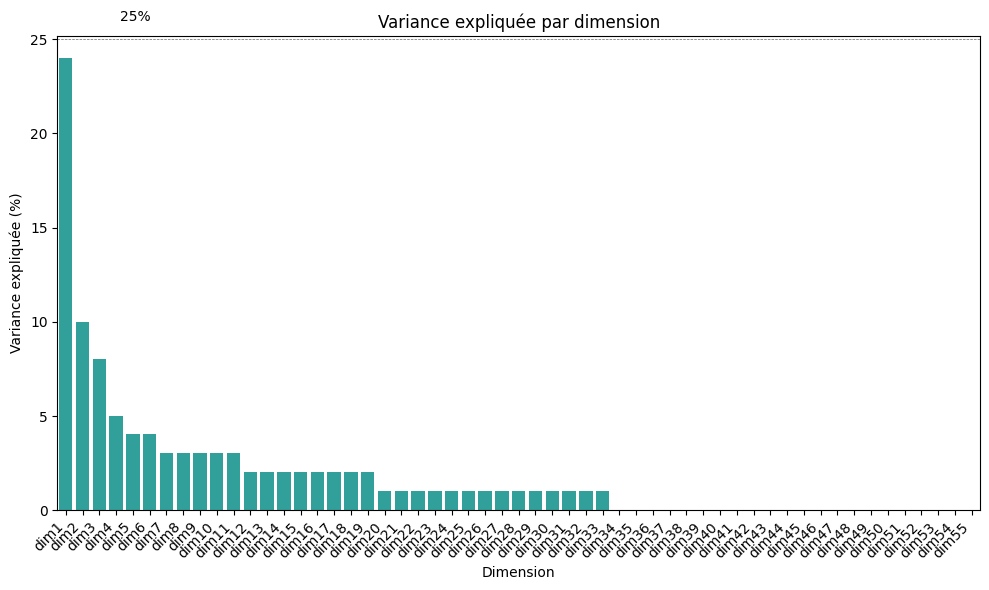

In [86]:
plt.figure(figsize=(10, 6))
g_comp = sns.barplot(x="dimension",
                     y="% variance expliquée",
                     palette=["lightseagreen"],
                     data=comp)


g_comp.set(ylabel="Variance expliquée (%)")
g_comp.set(xlabel="Dimension")
g_comp.set_title("Variance expliquée par dimension")


g_comp.set_xticklabels(g_comp.get_xticklabels(), rotation=45, horizontalalignment='right')


plt.axhline(y=25, linewidth=.5, color="dimgray", linestyle="--")
plt.text(3.25, 26, "25%")

plt.tight_layout()


plt.show()


In [87]:
# Quality of representation cos2
cos2 = np.square(pca.components_)
#Creating a dataframe with the cos2 of the variables
df_cos2 = pd.DataFrame(cos2, columns=df.columns, index=['PC{}'.format(i+1) for i in range(len(X_pca[1]))])
df_cos2

encounter_id           age           bmi        height  \
PC1   1.610093e-06  6.892369e-04  2.725914e-04  4.435121e-04   
PC2   2.600081e-07  1.192497e-04  2.032240e-04  8.113405e-04   
PC3   4.951079e-07  1.736693e-02  3.587222e-04  1.430274e-04   
PC4   6.406035e-06  4.788335e-02  4.486909e-03  3.056732e-03   
PC5   2.842744e-07  8.832044e-03  2.524976e-01  4.244330e-02   
PC6   2.512006e-05  8.458432e-03  3.541851e-04  1.655204e-02   
PC7   9.327879e-05  1.135466e-02  4.709472e-03  3.072809e-03   
PC8   4.683462e-05  5.456596e-03  3.526929e-03  1.791571e-03   
PC9   9.712376e-06  3.971516e-02  6.181959e-02  2.768992e-02   
PC10  5.999223e-06  1.652255e-05  4.115905e-02  9.420372e-03   
PC11  4.078975e-08  9.672517e-03  2.736129e-02  1.574985e-03   
PC12  1.293735e-06  9.527993e-05  4.599474e-02  9.680518e-03   
PC13  3.504335e-04  9.473056e-04  6.091890e-04  5.522474e-02   
PC14  6.211966e-03  7.169682e-03  2.590351e-02  9.215673e-02   
PC15  1.516023e-01  4.466989e-02  2.502697e-02  2.175615e-01   
PC16  8.389677e-01  3.249857e-03  8.853117e-03  5.841458e-02   
PC17  1.421491e-03  7.329680e-03  6.133398e-02  2.894997e-01   
PC18  2.363777e-04  1.744636e-02  1.157889e-02  3.062870e-02   
PC19  1.910566e-04  2.528420e-01  4.505152e-04  1.338211e-02   
PC20  8.716627e-05  2.281692e-01  2.942274e-03  9.076210e-03   
PC21  6.448071e-04  1.022202e-01  7.930981e-04  1.345535e-04   
PC22  3.261944e-06  1.250342e-01  3.318778e-03  9.195770e-03   
PC23  3.340938e-06  2.928964e-02  2.076803e-05  5.559152e-03   
PC24  1.120589e-05  1.684395e-03  2.002487e-04  1.953413e-04   
PC25  1.371645e-05  9.292192e-03  4.890225e-04  1.318821e-03   
PC26  5.144418e-06  4.899575e-03  3.474195e-04  4.774255e-05   
PC27  2.839697e-06  1.521947e-07  2.169298e-03  1.961295e-03   
PC28  2.901381e-06  8.510958e-03  5.783406e-05  4.115784e-04   
PC29  6.049898e-06  4.084004e-03  1.071109e-04  2.836877e-04   
PC30  1.730626e-05  2.924710e-04  1.420541e-04  2.001402e-05   
PC31  4.214698e-07  9.242447e-04  5.203836e-08  1.935298e-04   
PC32  6.710271e-07  4.909918e-04  1.949430e-04  3.981872e-05   
PC33  4.961075e-07  7.026741e-04  3.900332e-05  3.150142e-05   
PC34  1.146184e-07  6.171905e-06  1.091339e-07  6.444275e-06   
PC35  1.705016e-05  5.065954e-04  1.649748e-05  1.465025e-06   
PC36  8.009274e-07  7.111085e-05  1.462257e-05  1.701892e-04   
PC37  2.851259e-08  1.794783e-05  5.225976e-07  8.977295e-06   
PC38  1.151716e-06  7.276102e-05  2.596779e-05  2.885589e-06   
PC39  7.226588e-07  3.781636e-05  6.676811e-06  2.185676e-05   
PC40  4.585768e-09  1.999305e-06  1.567229e-06  2.441578e-06   
PC41  7.125560e-08  6.800232e-06  2.511840e-08  1.108501e-05   
PC42  6.168705e-08  3.812548e-05  1.077487e-06  5.125006e-10   
PC43  9.981182e-07  2.310594e-04  1.558341e-06  2.391265e-06   
PC44  2.291874e-06  5.934053e-05  2.198662e-06  4.256061e-06   
PC45  5.267609e-08  2.800111e-05  4.805548e-05  1.881465e-05   
PC46  1.891777e-06  8.861025e-07  2.606652e-05  2.471242e-06   
PC47  2.231771e-06  2.885215e-08  4.124604e-01  9.769897e-02   
PC48  1.727268e-07  2.482658e-06  2.316974e-05  1.790118e-05   
PC49  3.253485e-07  1.104561e-06  2.958840e-05  6.930922e-06   
PC50  6.307112e-08  7.531180e-06  8.566439e-06  1.210774e-06   
PC51  2.067363e-09  3.302941e-07  6.093240e-06  3.021767e-06   
PC52  4.234322e-08  6.454075e-08  1.530017e-06  9.125712e-07   
PC53  6.541670e-10  9.194665e-08  1.718623e-06  2.188564e-07   
PC54  1.198796e-08  1.388078e-08  1.367516e-06  2.622035e-07   
PC55  1.184112e-09  6.682012e-08  2.173146e-07  5.507454e-09   

      pre_icu_los_days        weight  apache_2_diagnosis  apache_3j_diagnosis  \
PC1       4.076207e-04  6.364972e-04        2.115924e-04         7.148115e-04   
PC2       2.457895e-04  1.297617e-06        8.715913e-03         6.359120e-03   
PC3       7.219778e-04  1.764342e-04        2.751471e-03         6.387614e-05   
PC4       2.088204e-05  1.602368e-03        1.073272e-02         3.716232e-02   
PC5       1.8276

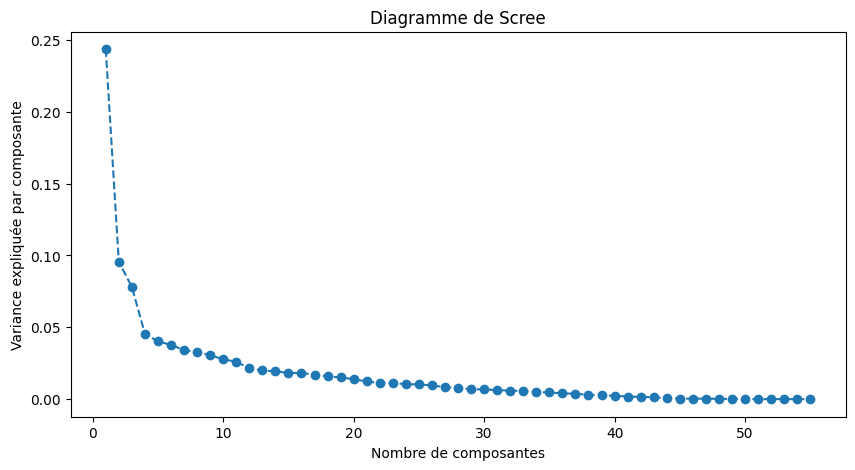

the number of component retained is 15


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [88]:
explained_variance = pca.explained_variance_ratio_

# Creation of Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Diagramme de Scree')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée par composante')
plt.show()

# application of the Kaiser criterion retain the eigenvalue > 1
# In the context of PCA it is retaining component with an explained variance ratio > 1/number of variables

num_variables = df.shape[1]
seuil_kaiser = 1 / num_variables
components_to_retain = sum(explained_variance > seuil_kaiser)
print(f'the number of component retained is {components_to_retain}')
(explained_variance > seuil_kaiser)

In [89]:
# Applying the pca for and retrieving only the 15 first components
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(scaled_data)
df_pca = pd.DataFrame(data=X_pca, columns=[f"Dimension_{i+1}" for i in range(15)])

In [90]:
def avatarize(k, X_pca, comp, df):
  nn_model = NearestNeighbors(n_neighbors=k)
  nn_model.fit(X_pca)
  distances, indices = nn_model.kneighbors(X_pca)
  newcoord = np.empty((X_pca.shape[0], comp))
  newcoord.fill(np.nan)
  for i in range(len(df)):

    distances_i = distances[i,]
    inv_disti = np.where(distances_i < 1e-9, 1, 1/distances_i)

    Pi = inv_disti * np.random.exponential(scale=1, size=k) * 0.5**(np.random.permutation(k)+1)
    Wi = Pi / np.sum(Pi)
    for j in range(comp):

        newcoord[i,j] = np.average(X_pca[indices[i,:], j], weights=Wi)

  newcoord_original_space = pca.inverse_transform(newcoord)


  df_avatarised =  Scaler.inverse_transform(newcoord_original_space)
  df_avatarized = pd.DataFrame(df_avatarised)
  nom_de_colonne = df.columns
  df_avatarized.columns = nom_de_colonne


  df_avatarized = df_avatarized.round(0)

  return df_avatarized





In [91]:
df_avatarized = avatarize(12,X_pca,15,df)

In [92]:
df_avatarized

encounter_id   age   bmi  height  pre_icu_los_days  weight  \
0           36181.0  65.0  24.0   172.0               2.0    72.0   
1           43581.0  44.0  23.0   176.0              -1.0    73.0   
2           42999.0  62.0  30.0   173.0               0.0    89.0   
3           35402.0  56.0  30.0   182.0               0.0    98.0   
4           42215.0  81.0  27.0   168.0              -0.0    77.0   
...             ...   ...   ...     ...               ...     ...   
82537       46275.0  63.0  31.0   171.0               1.0    91.0   
82538       47575.0  57.0  33.0   169.0              -1.0    93.0   
82539       37418.0  80.0  23.0   163.0               3.0    62.0   
82540       47518.0  64.0  24.0   168.0              -0.0    67.0   
82541       48611.0  55.0  40.0   172.0               1.0   117.0   

       apache_2_diagnosis  apache_3j_diagnosis  heart_rate_apache  map_apache  \
0                   144.0                141.0              100.0       117.0   
1                   169.0                413.0               93.0        92.0   
2                   132.0                313.0               98.0       107.0   
3                   130.0                210.0               73.0       106.0   
4                   118.0                205.0               65.0        85.0   
...                   ...                  ...                ...         ...   
82537               273.0               1153.0               82.0        68.0   
82538               139.0                473.0              119.0        80.0   
82539               224.0                681.0               82.0        82.0   
82540               109.0                344.0              143.0        62.0   
82541               246.0                814.0              102.0        92.0   

       resprate_apache  temp_apache  d1_diasbp_max  d1_diasbp_min  \
0                 43.0         36.0           94.0           69.0   
1                 21.0         36.0          107.0           56.0   
2                 44.0         37.0           88.0           59.0   
3                 19.0         36.0          103.0           61.0   
4                 26.0         36.0           85.0           42.0   
...                ...          ...            ...            ...   
82537             11.0         36.0           74.0           41.0   
82538             33.0         36.0           82.0           51.0   
82539             20.0         36.0           97.0           33.0   
82540             40.0         36.0           78.0           40.0   
82541             15.0         36.0           93.0           51.0   

       d1_diasbp_noninvasive_max  d1_diasbp_noninvasive_min  d1_heartrate_max  \
0                           94.0                       69.0              98.0   
1                          106.0                       56.0             100.0   
2                           88.0                       59.0             103.0   
3                          102.0                       61.0              84.0   
4                           85.0                       42.0              80.0   
...                          ...                        ...               ...   
82537                       75.0                       41.0              93.0   
82538                       82.0                       51.0             116.0   
82539                       97.0                       33.0              93.0   
82540                       78.0                       40.0             136.0   
82541                       93.0                       51.0             103.0   

       d1_heartrate_min  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  \
0                  76.0       116.0        88.0                   116.0   
1                  62.0       115.0        64.0                   115.0   
2                  66.0       113.0        79.0                   113.0   
3                  56.0       117.0        76.0                   117.0   
4                  53.0     

# Cheking the preservation of the statistical relevance



With k = 12 (0.01% of the total individuals), we first compared the distribution of each variable between the original and synthetic data. For age, height, apache_2_diagnosis, apache_3j_diagnosis, heart_rate_apache, map_apache, resprate_apache, and temp_apache, the distributions do not overlap well; however, for the rest, we observed a good overlap of the variables. Next, we performed factor analysis of mixed data (PCA) projection of the first two components. The analysis revealed that the original data and avatar data fully overlapped.


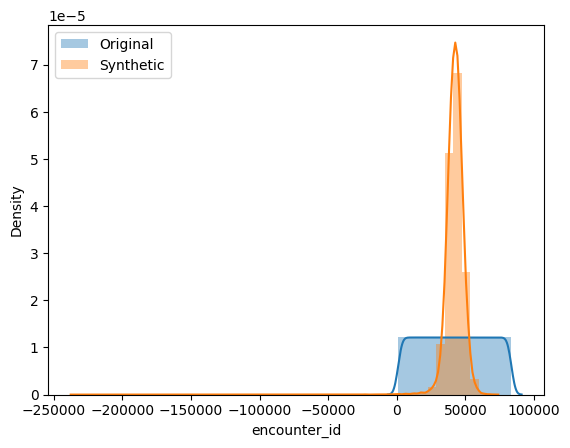

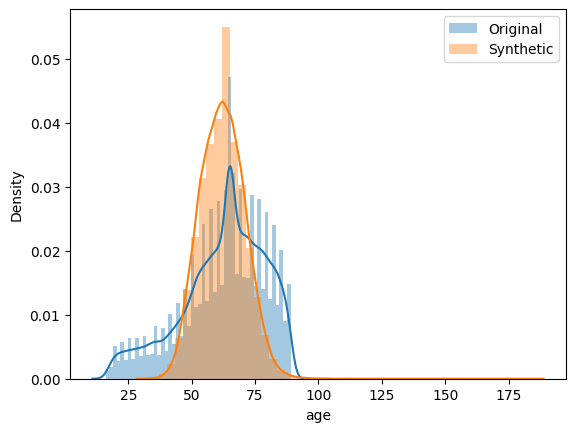

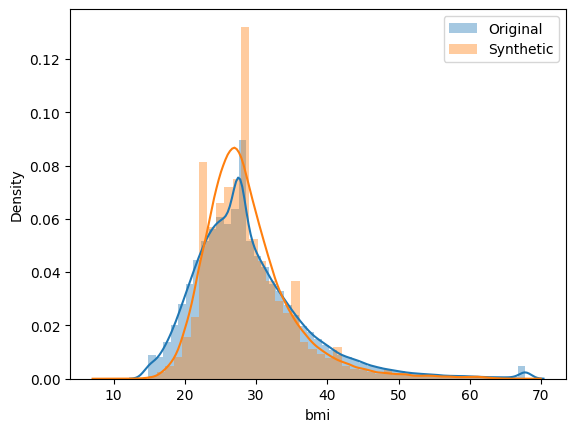

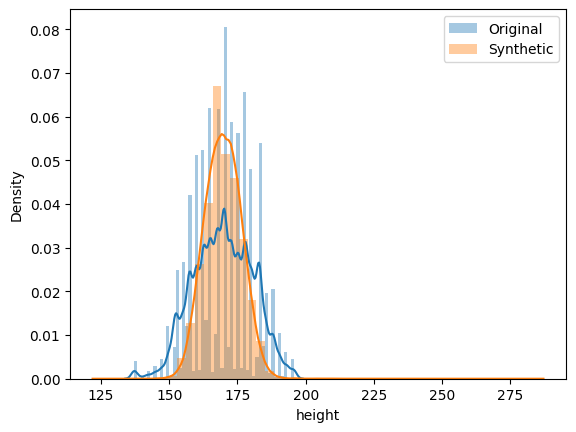

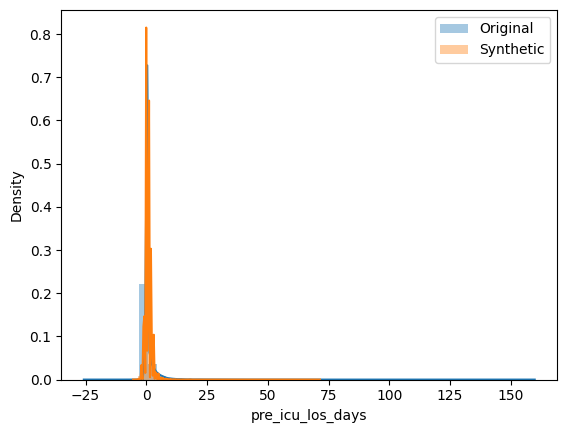

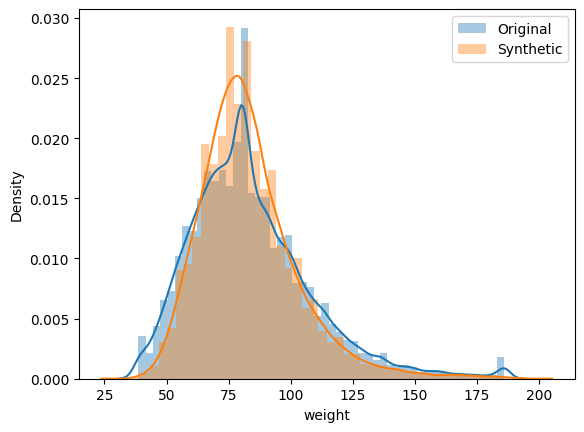

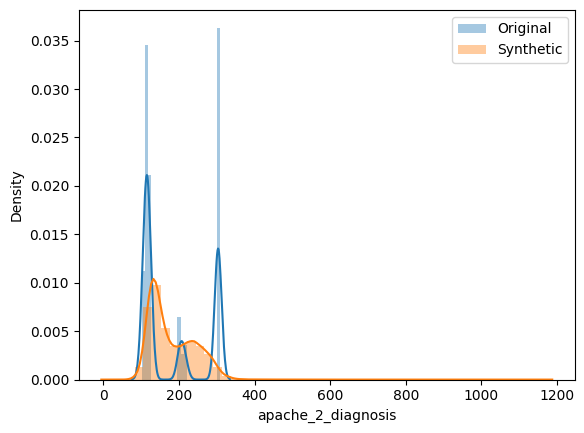

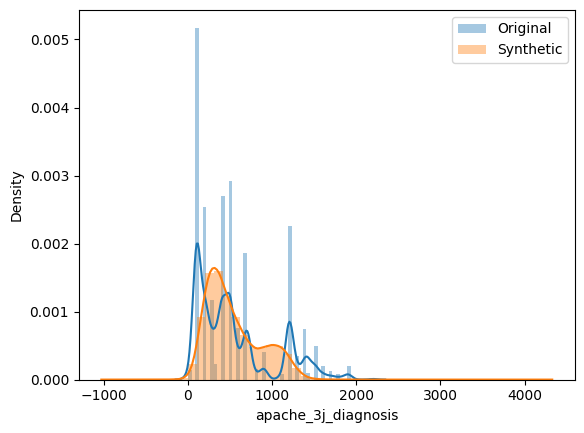

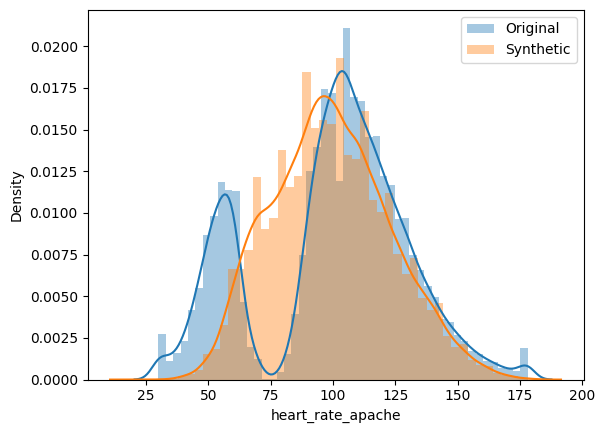

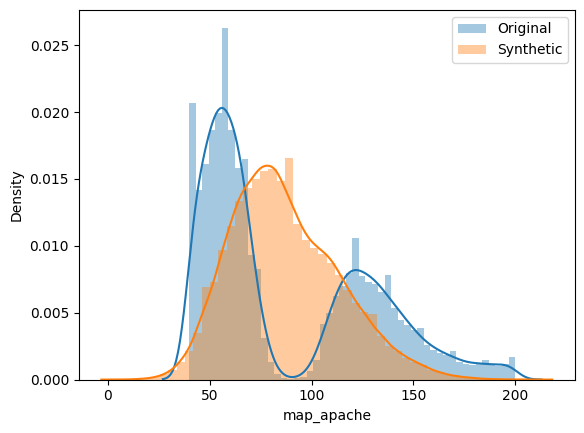

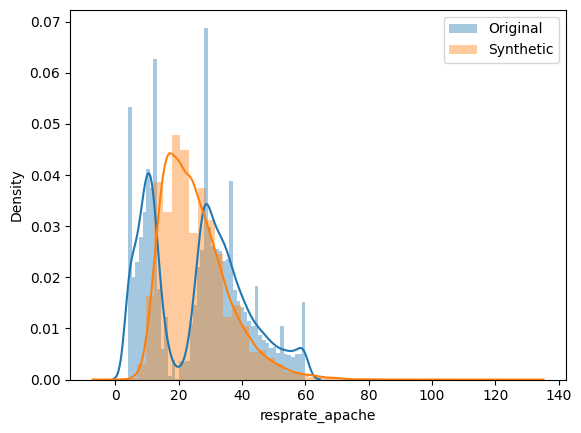

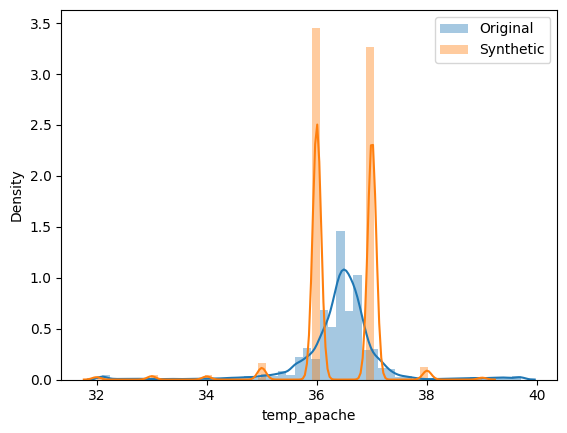

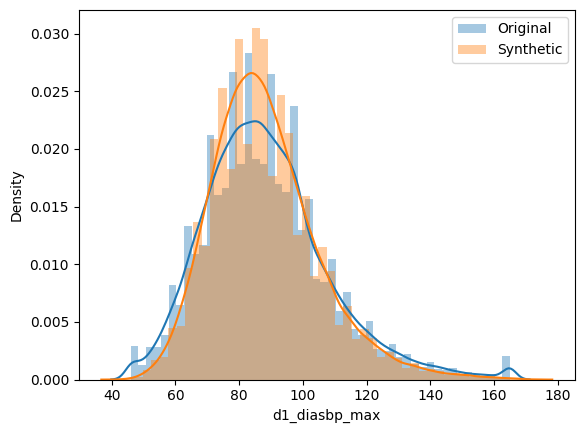

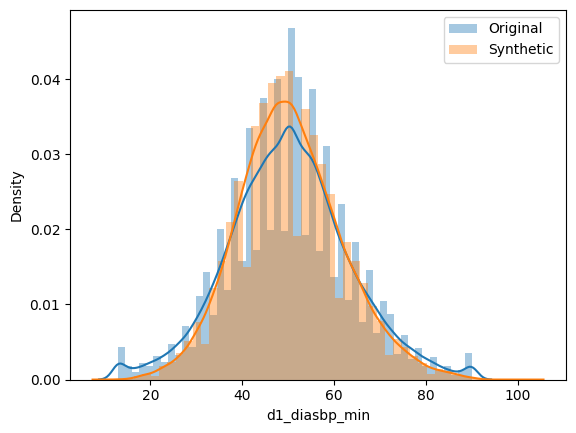

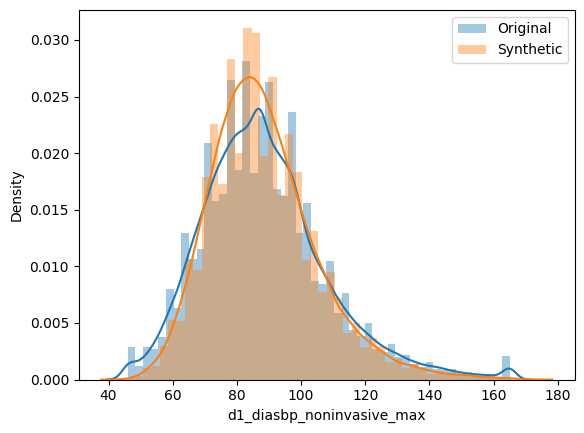

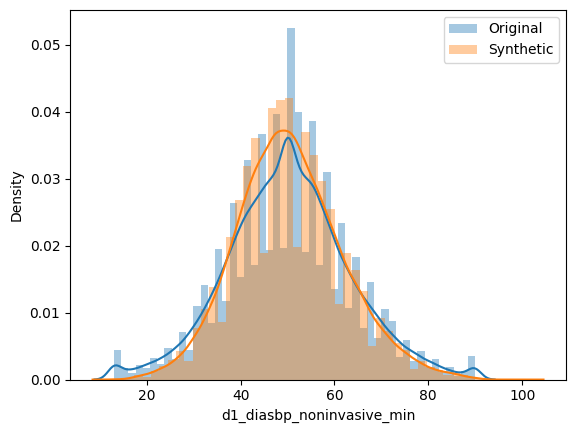

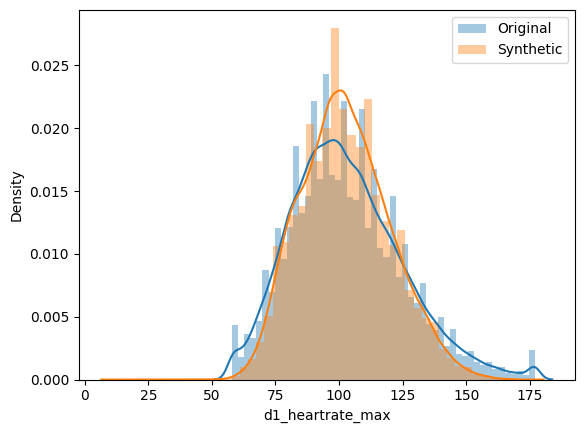

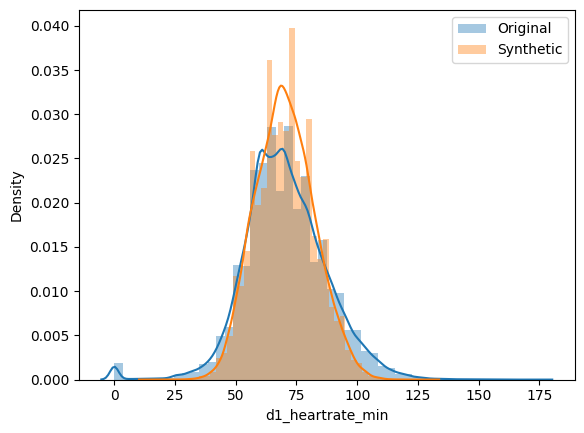

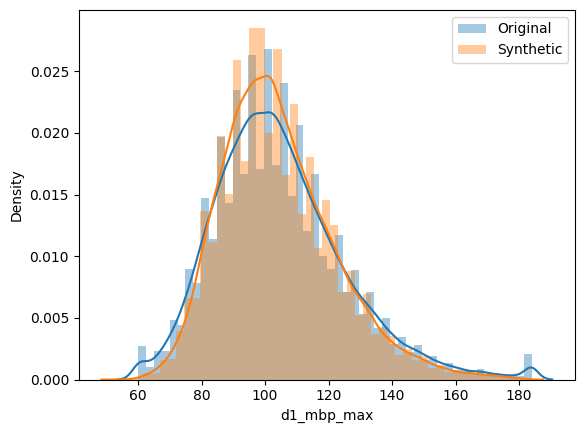

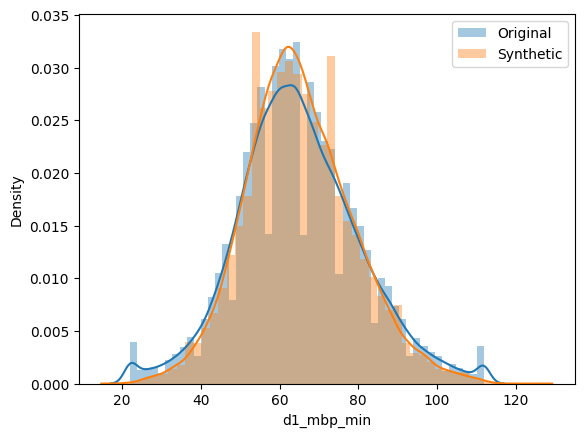

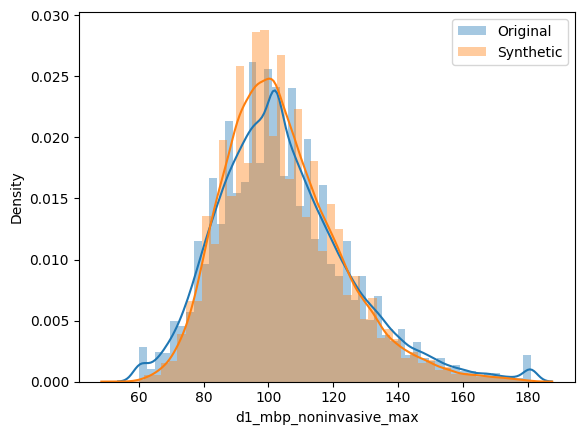

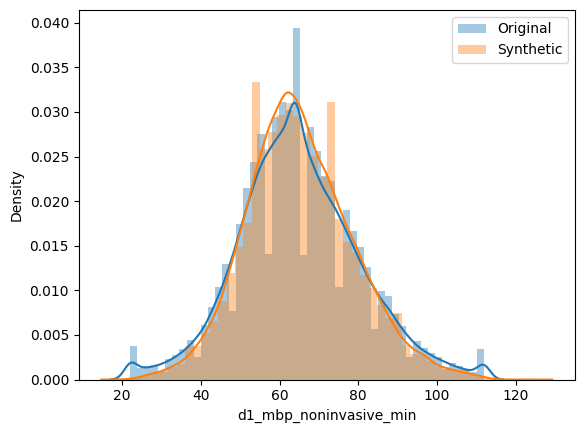

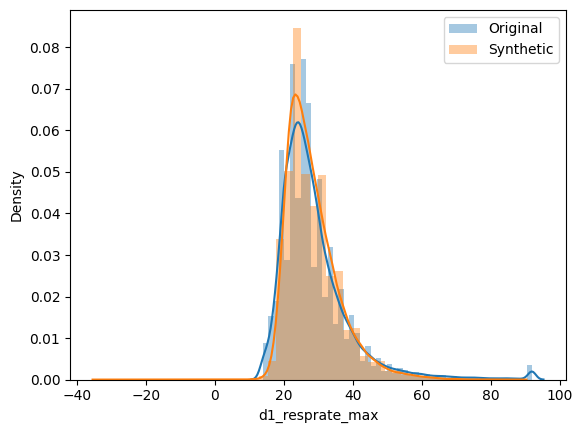

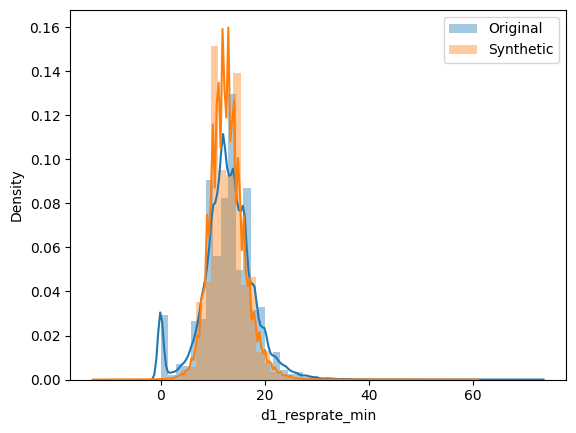

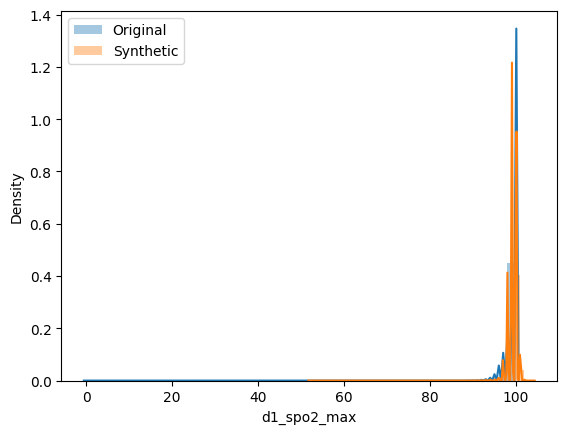

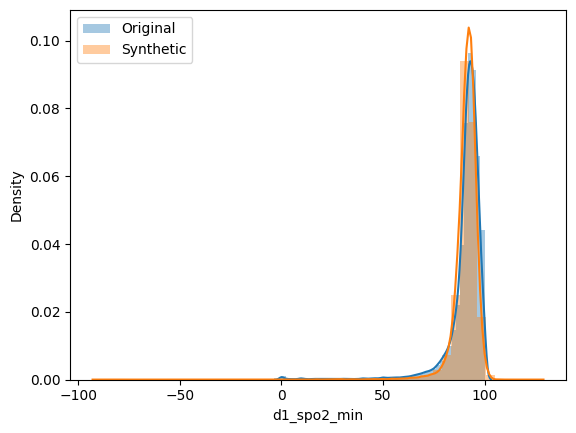

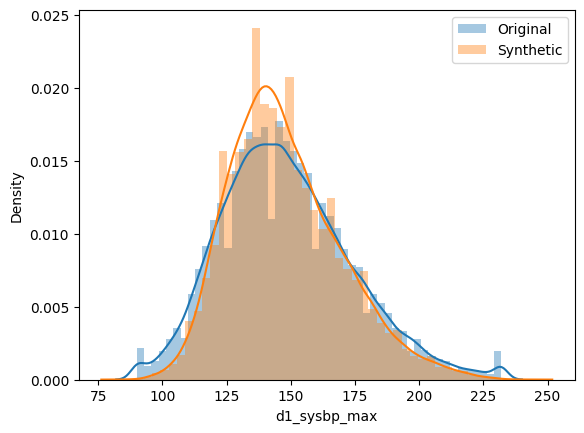

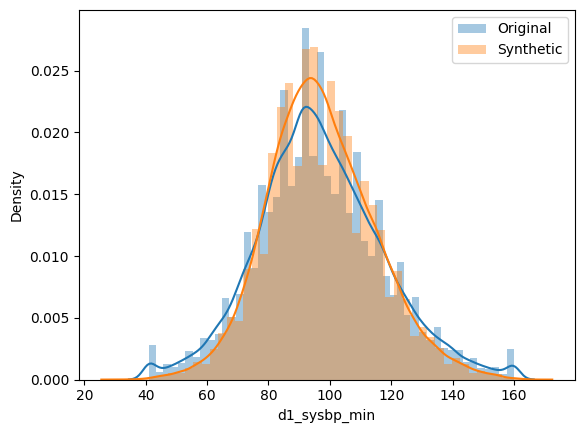

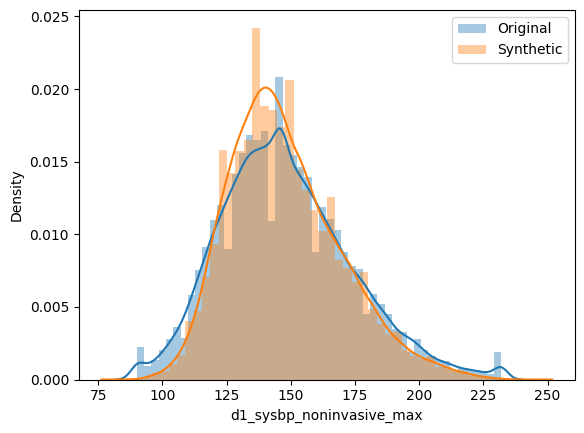

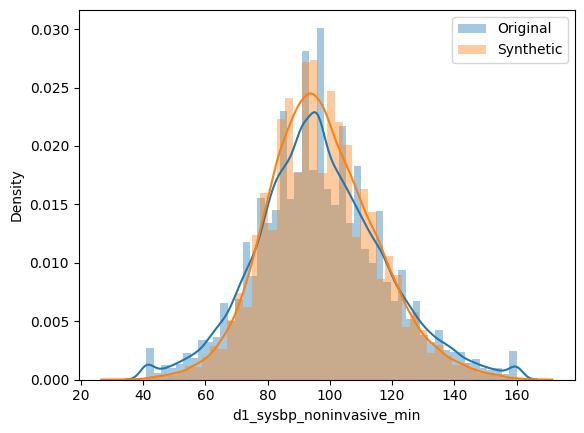

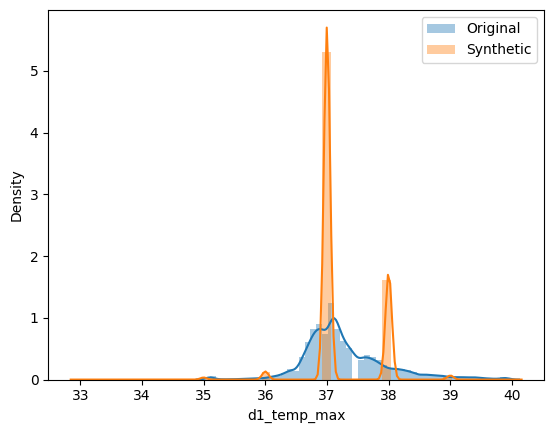

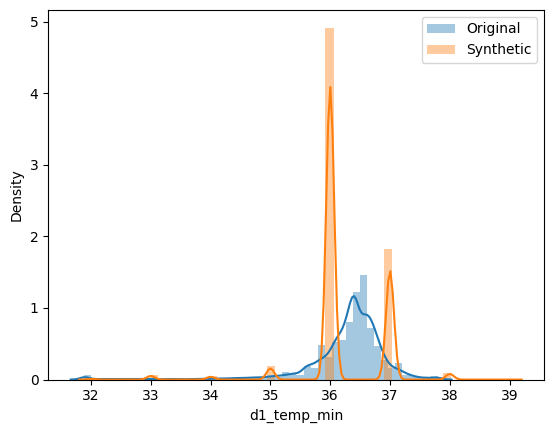

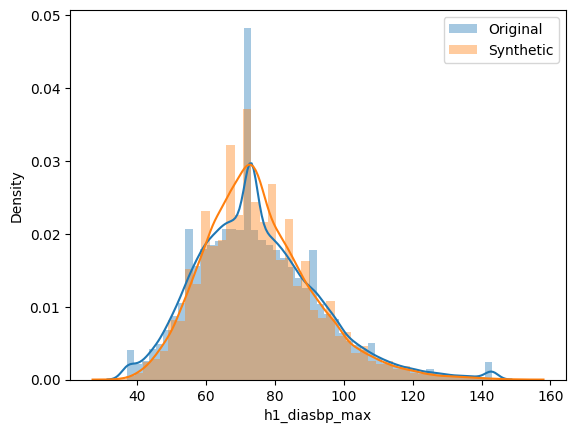

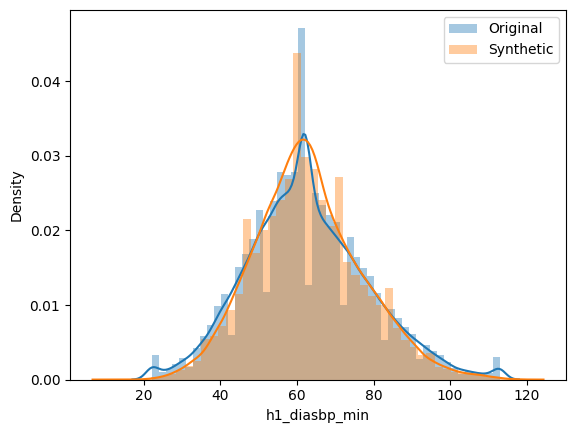

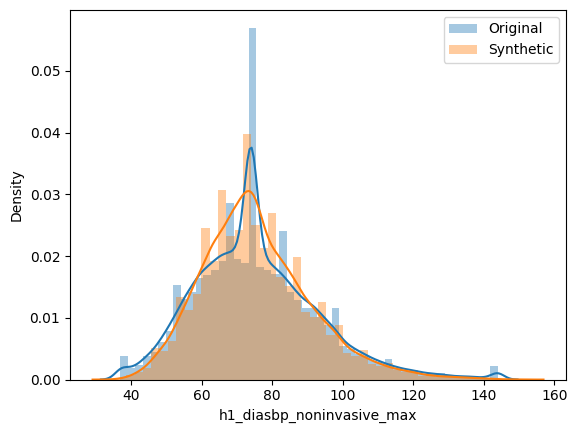

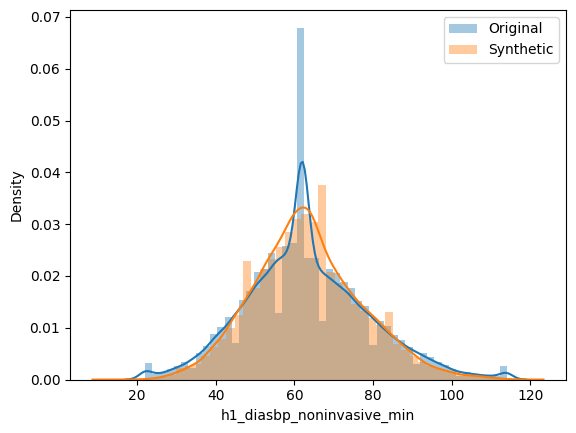

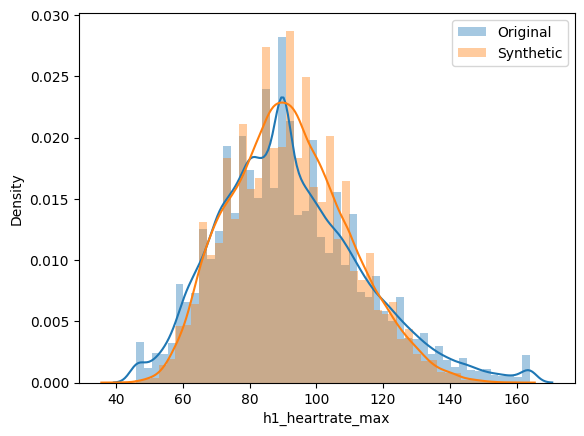

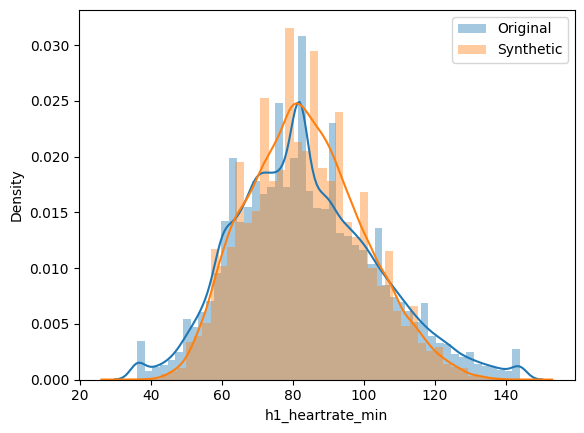

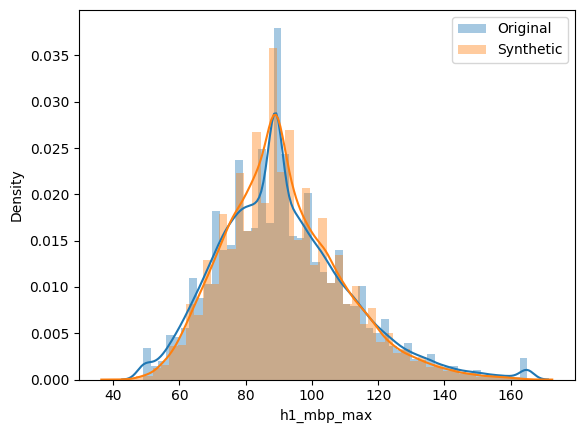

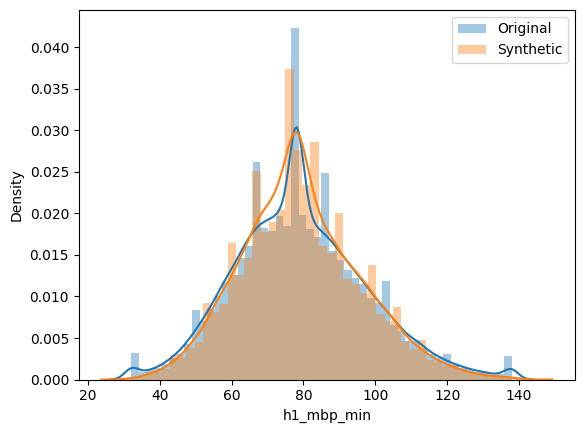

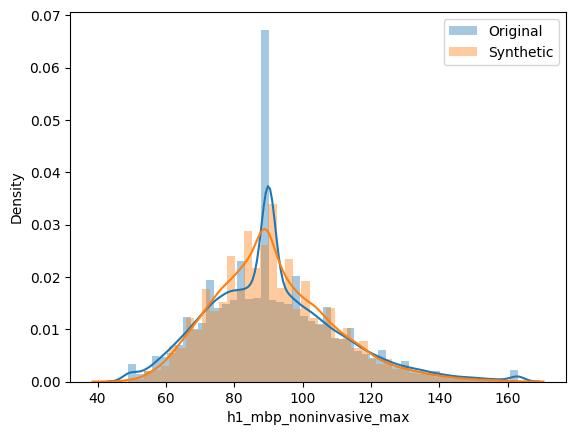

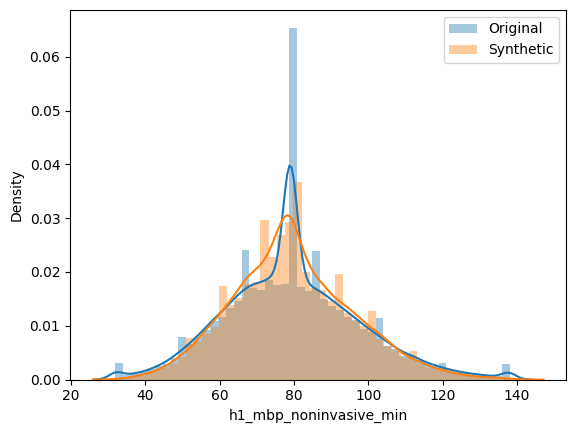

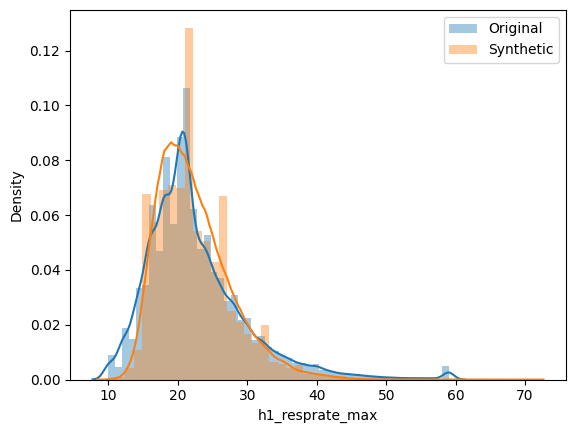

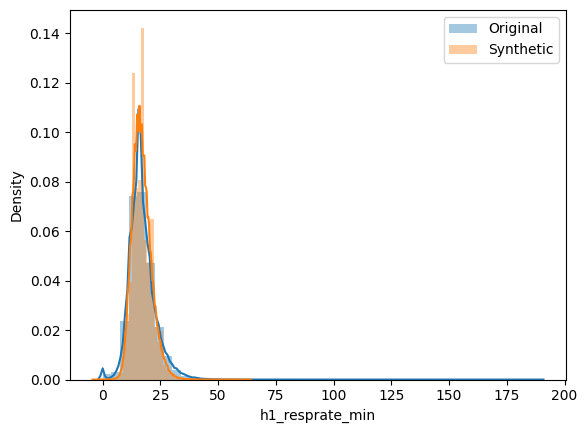

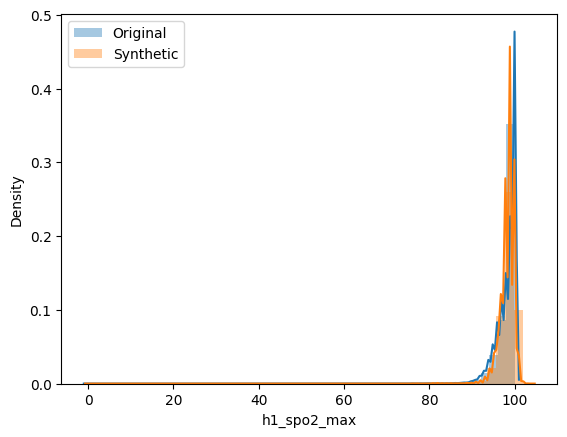

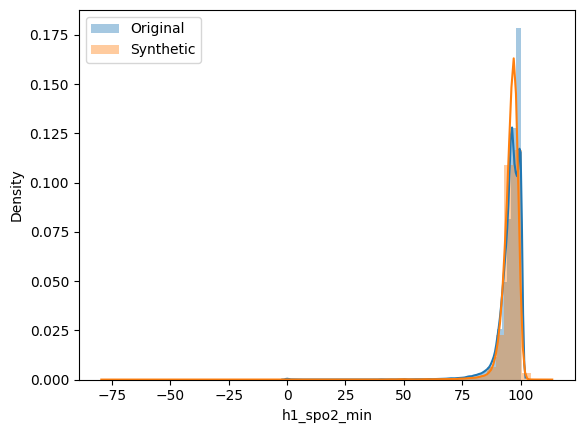

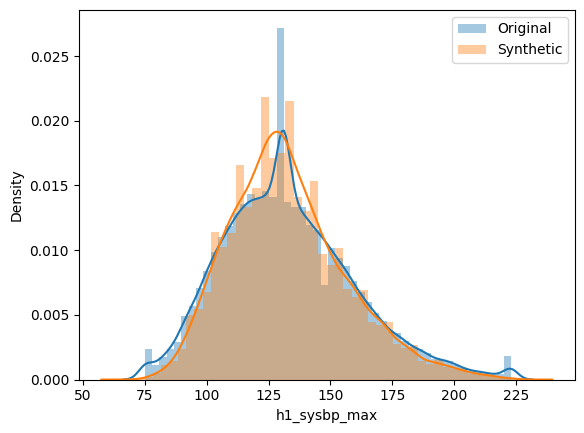

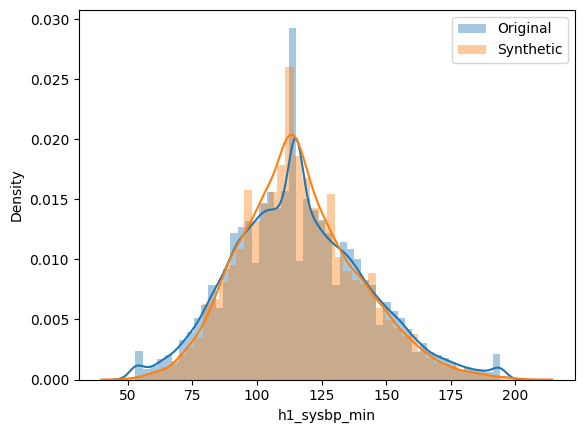

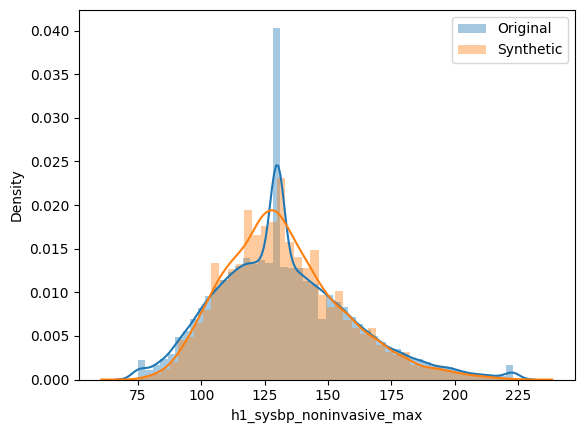

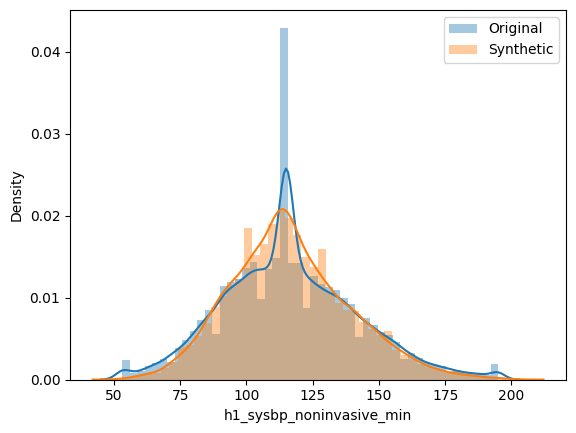

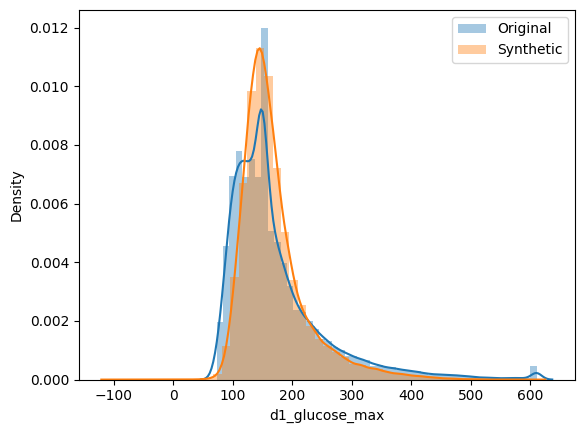

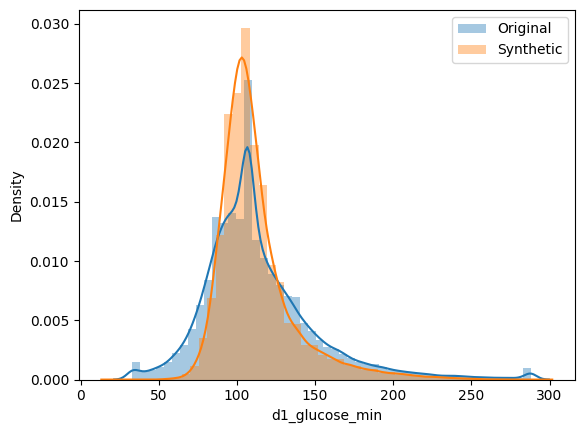

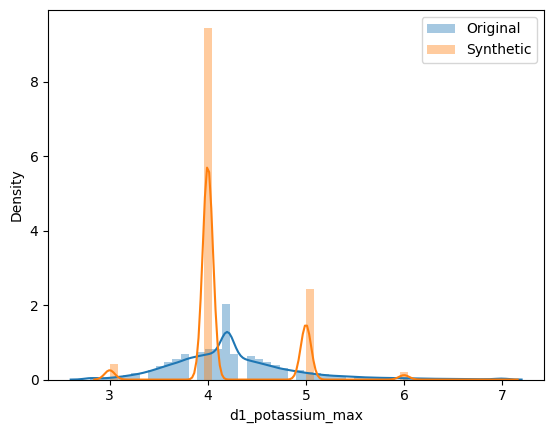

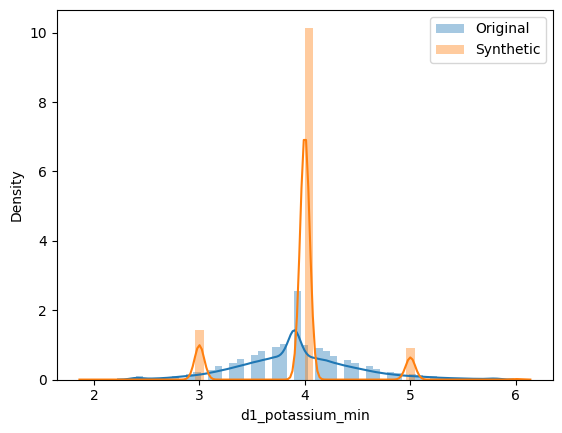

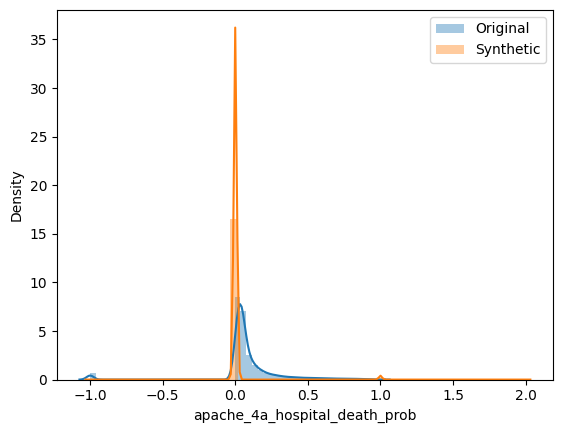

In [93]:
import warnings

# Ignoring warnnings
warnings.filterwarnings("ignore")

for col in df_imputed.columns:
    plt.figure()
    sns.distplot(df_imputed[col], label='Original')
    sns.distplot(df_avatarized[col], label='Synthetic')
    plt.legend()

In [94]:
def plotPca(df_imputed, df_avatarized):

  Scaler = StandardScaler()
  scaled_data = Scaler.fit_transform(df_imputed)
  scaled_data_avatar = Scaler.fit_transform(df_avatarized)
  acp1 = PCA(n_components = 2)

  projection_data_original = acp1.fit_transform(scaled_data)
  projection_data_avatar = acp1.fit_transform(scaled_data_avatar)

  plt.figure(figsize=(20, 15))


  plt.scatter(projection_data_original[:, 0], projection_data_original[:, 1], color='orange', label='Données originales', alpha=0.7, s=20)
  plt.scatter(projection_data_avatar[:, 0], projection_data_avatar[:, 1], color='green', label='Données Avatar', alpha=0.3, s=20)
  plt.legend()
  plt.xlabel('Premier composant principal')
  plt.ylabel('Deuxième composant principal')
  plt.title('Projection ACP des données originales et Avatar')
  plt.show()









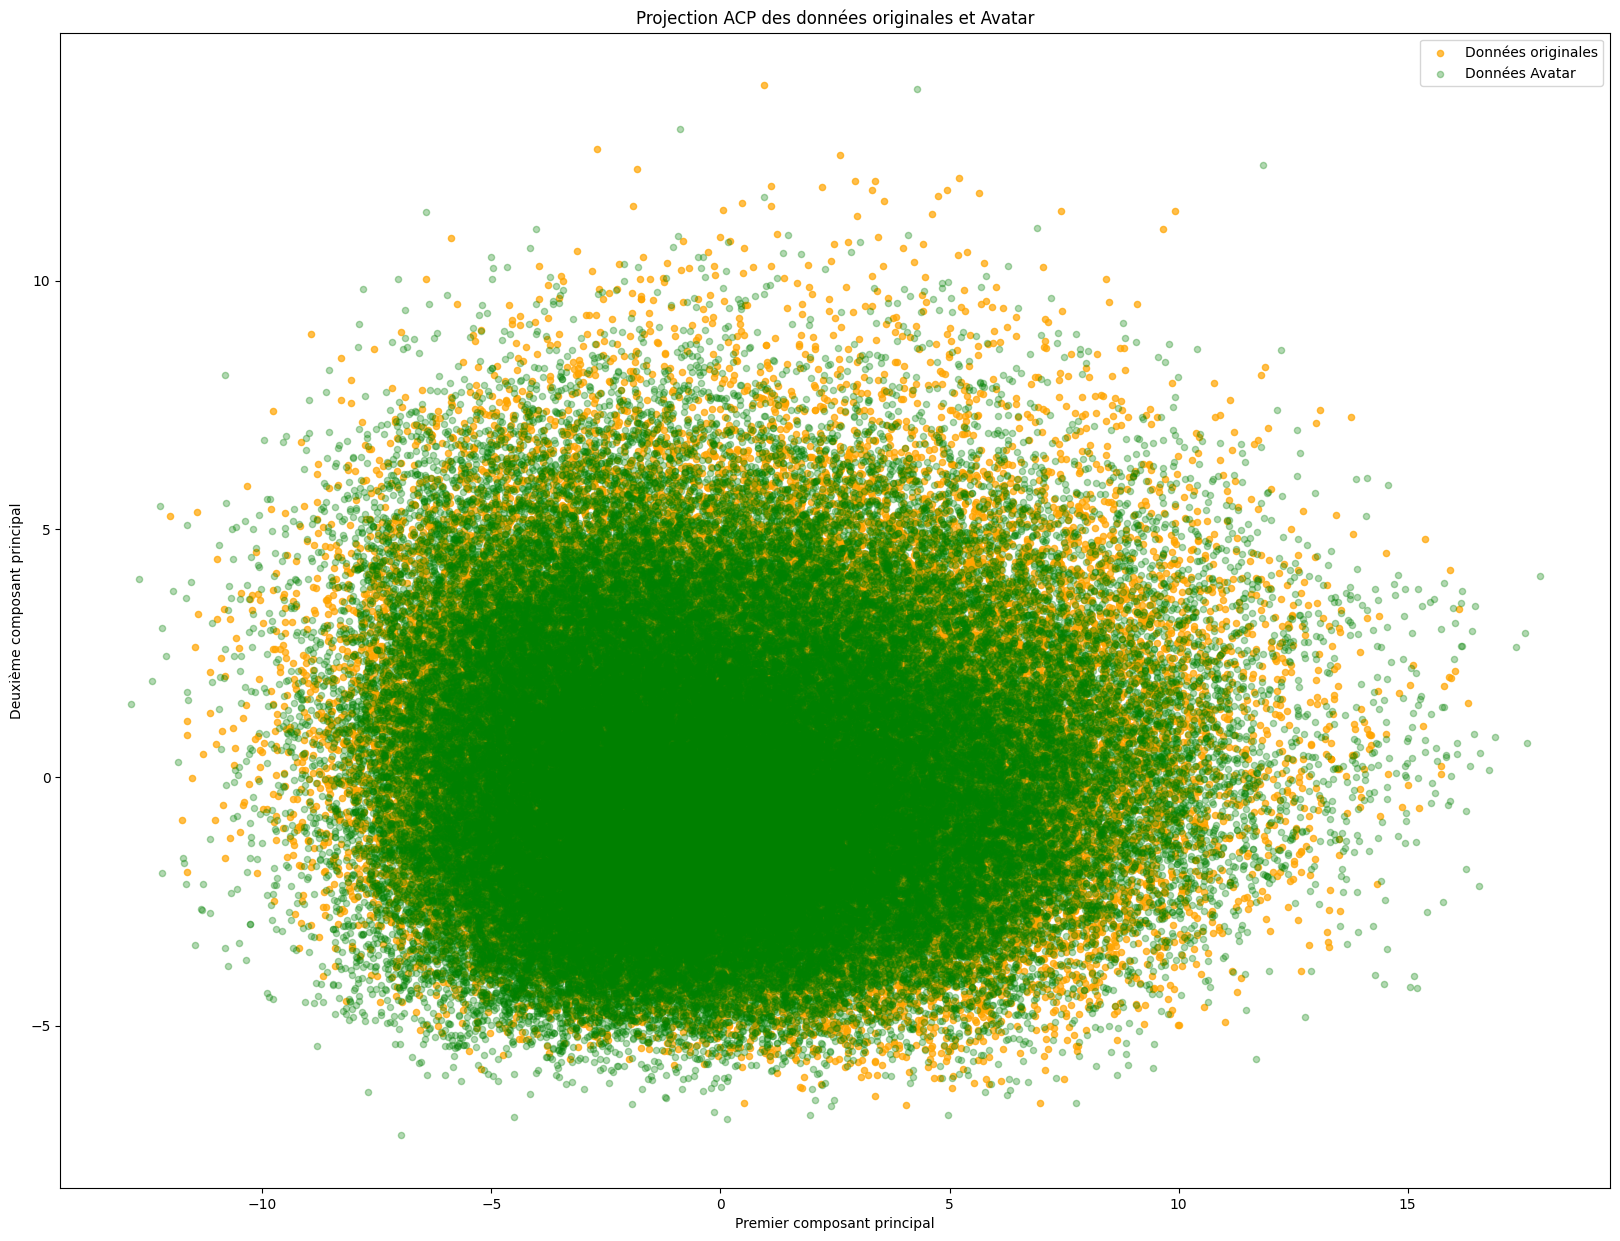

In [95]:
plotPca(df_imputed, df_avatarized)

# Checking the preservation of privacy

We compared the Distance to Closest Record (DCR), defined as the Euclidean distance between each synthetic record and its closest corresponding real neighbor, and the Nearest Neighbor Distance Ratio (NNDR), which is the ratio between the Euclidean distance of the closest and the distance of the second closest real neighbor for each synthetic record. NNDR is bounded between [0, 1]. We found a value of 3.35 for DCR (Target > 0.3), indicating that the avatar data provides a good level of privacy. Regarding NNDR, we obtained a value of 0.93. In terms of privacy, the avatar data presents satisfactory results for NNDR (Target ≥ 0.8). Of course, these metrics are not sufficient, and we need to conduct other tests.


## Calculating the DCR


In [96]:
def DCR(df_imputed, df_avatarized):
  model = NearestNeighbors(n_neighbors=1)
  df_imputed_scaled = Scaler.fit_transform(df_imputed)
  df_avatarized = Scaler.fit_transform(df_avatarized)
  model.fit(df_imputed_scaled)
  distances, indices = model.kneighbors(df_avatarized)
  nearest_neighbors_df = pd.DataFrame({'Plus proche voisin': indices[:, 0], 'Distance': distances[:, 0]})
  median = nearest_neighbors_df['Distance'].median()

  return print(f'the value of DCR is {median}'),print(nearest_neighbors_df )



In [97]:
DCR(df_imputed, df_avatarized)

the value of DCR is 3.3529467737376146
       Plus proche voisin  Distance
0                       0  3.519357
1                   50124  2.921711
2                   26544  3.370124
3                   18546  2.361379
4                   38422  3.801839
...                   ...       ...
82537               52840  3.328292
82538               77135  3.139467
82539               64713  3.644333
82540               68732  3.625160
82541               66226  3.171123

[82542 rows x 2 columns]


(None, None)

In [98]:
def NNDR(df_imputed, df_avatarized):
  model1 = NearestNeighbors(n_neighbors=2)
  df_imputed_scaled = Scaler.fit_transform(df_imputed)
  df_avatarized = Scaler.fit_transform(df_avatarized)
  model1.fit(df_imputed_scaled)
  distances, indices = model1.kneighbors(df_avatarized)
  nndr = distances[:, 0] / distances[:, 1]
  nndr = pd.DataFrame(nndr)
  return print(f'the value of NNDR is {nndr.median()}'),nndr

In [99]:
NNDR(df_imputed, df_avatarized)

the value of NNDR is 0    0.934736
dtype: float64


(None,
               0
 0      0.971954
 1      0.774886
 2      0.979842
 3      0.913220
 4      0.985159
 ...         ...
 82537  0.967789
 82538  0.908334
 82539  0.883969
 82540  0.890940
 82541  0.836606
 
 [82542 rows x 1 columns])

# Impact of local model size on avatar generation

The number of 'k' neighbors is a crucial parameter in the Avatar method. We are going to compare a low value of 'k' (k = 12, 0.015% of individuals) as we did previously, and a higher value for 'k' (k = 200, 2.5% of individuals)


In [100]:
df_avatarized1 = avatarize(200,X_pca,15,df)

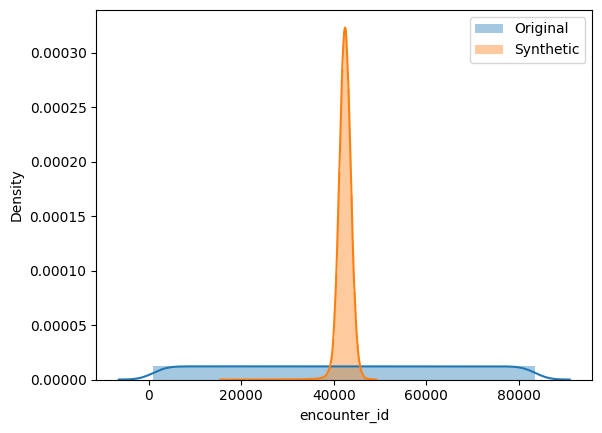

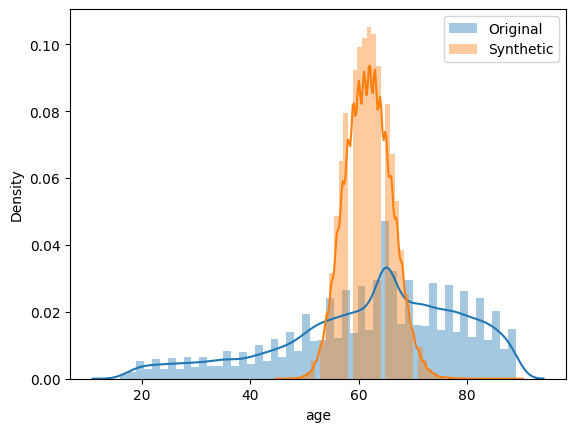

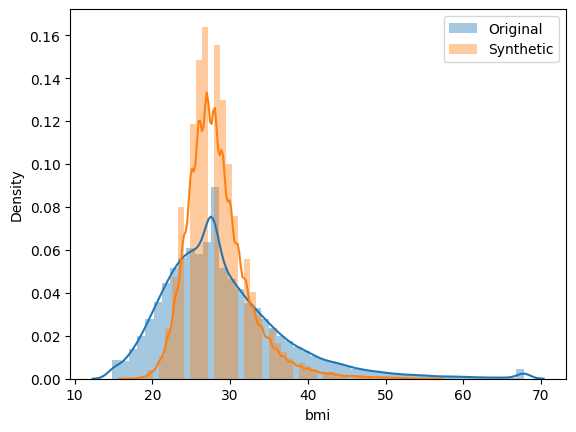

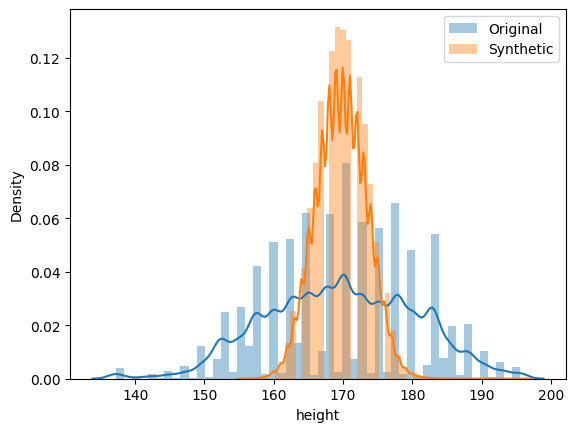

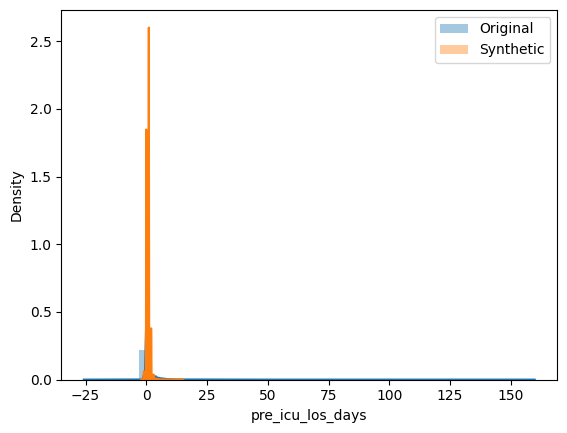

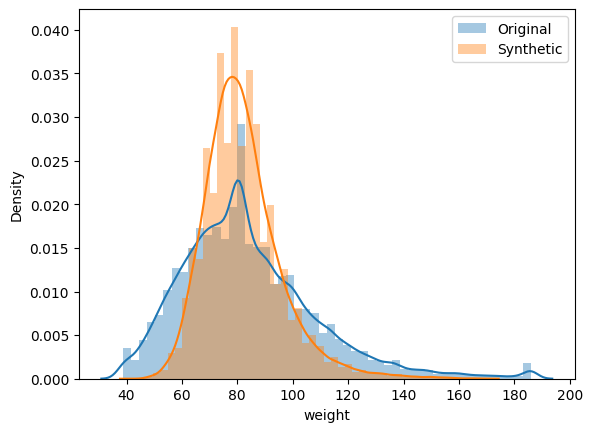

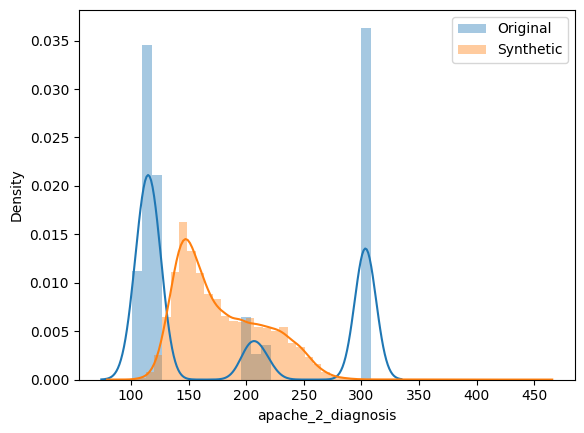

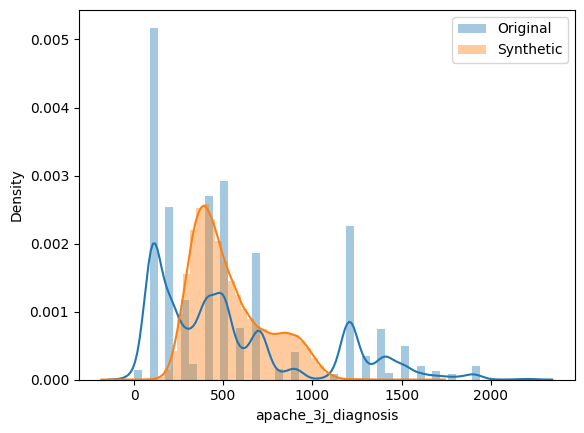

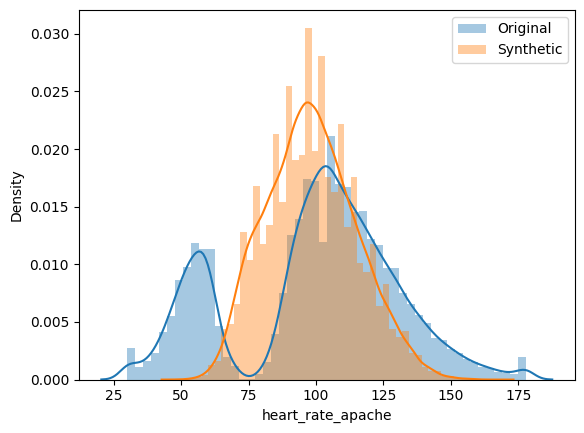

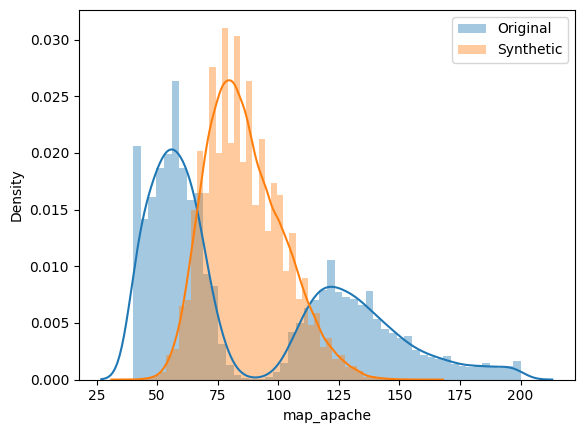

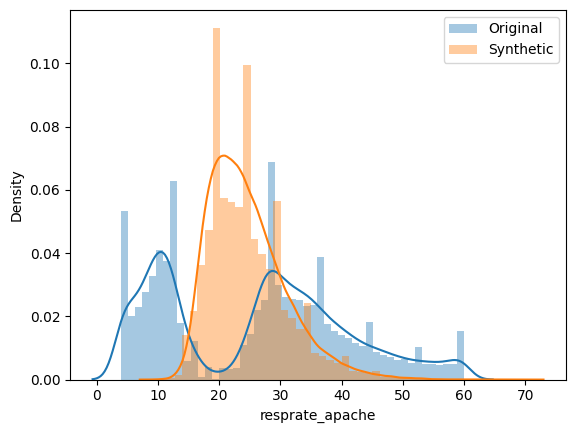

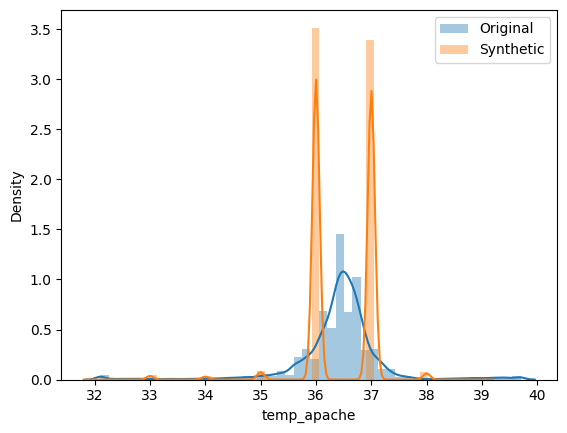

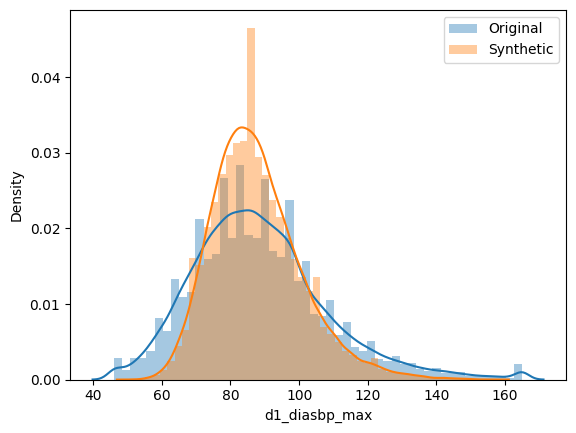

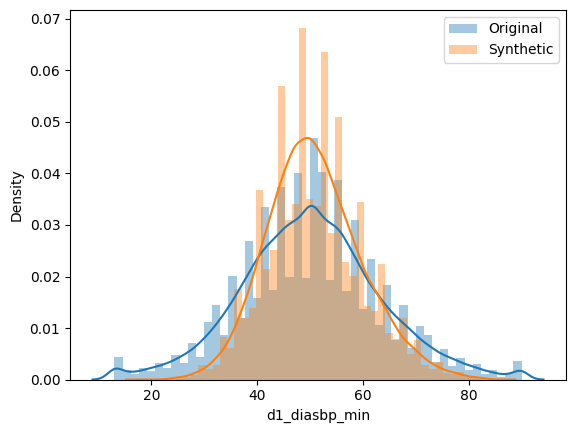

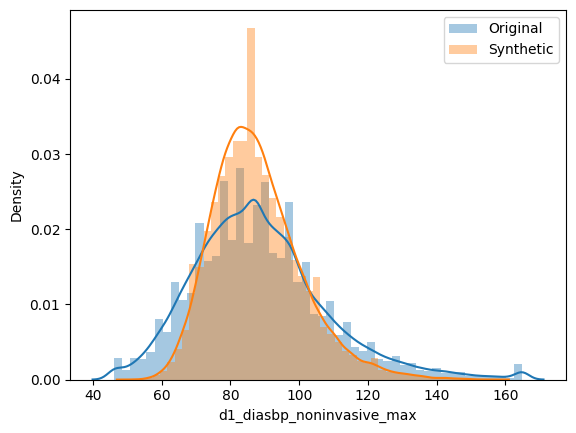

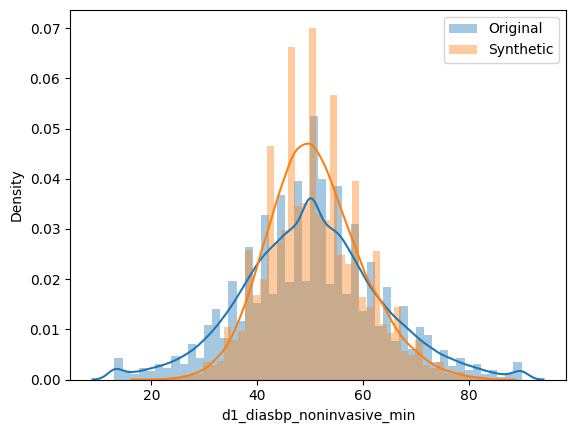

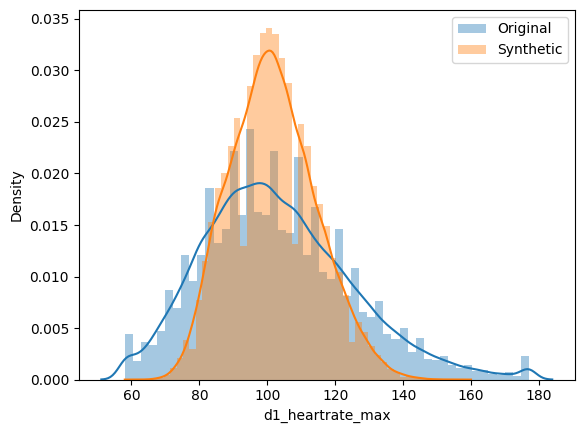

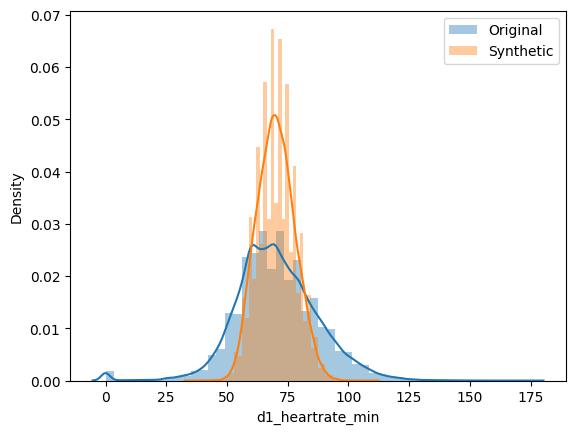

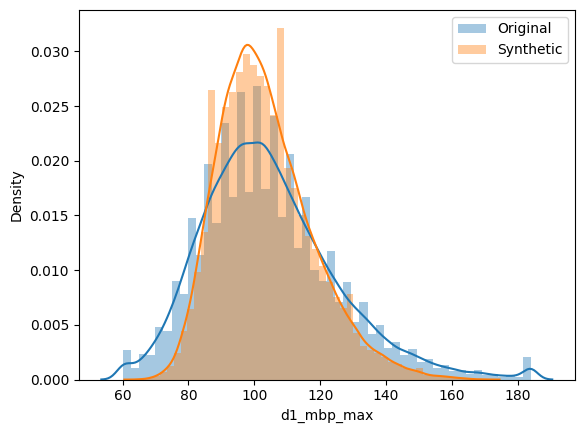

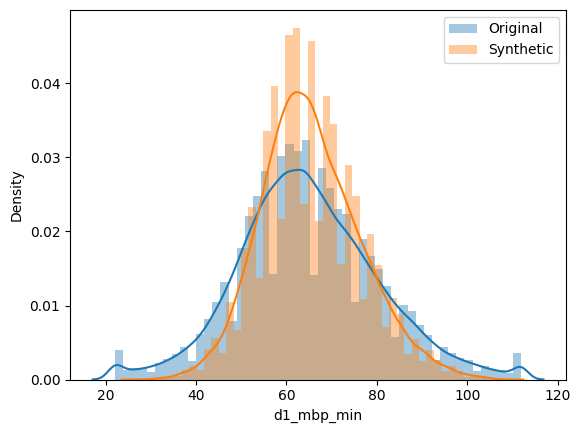

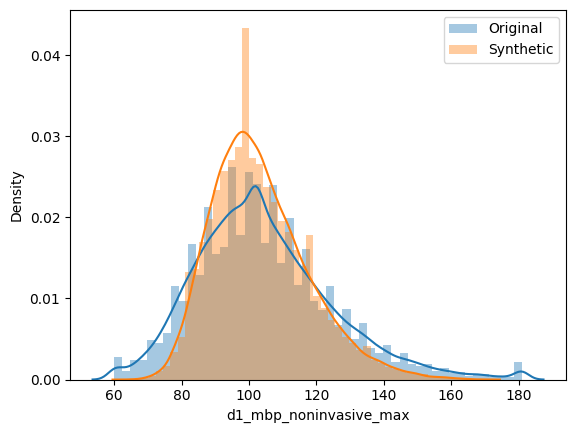

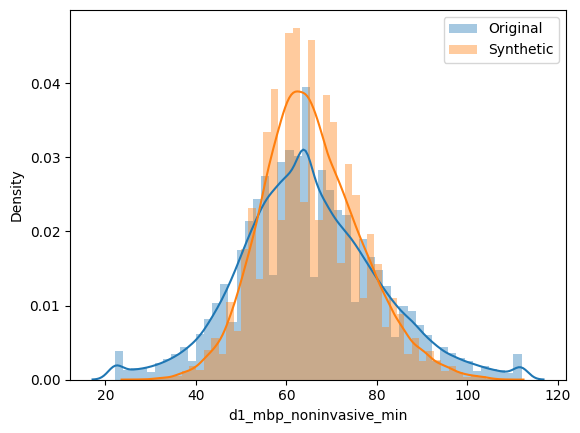

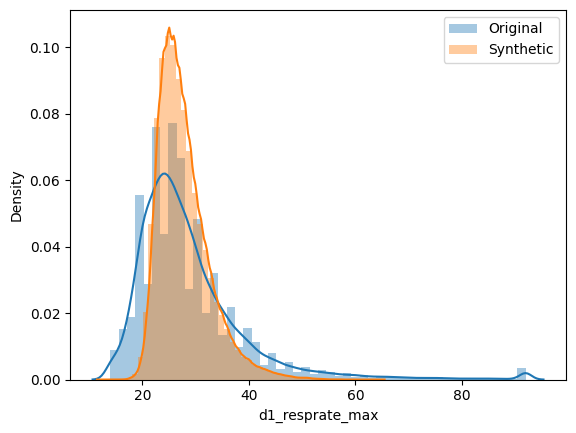

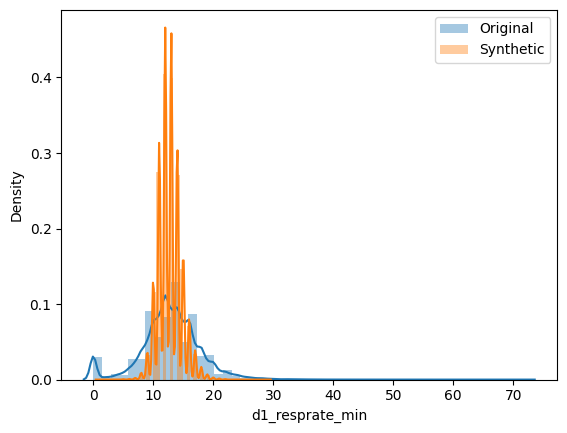

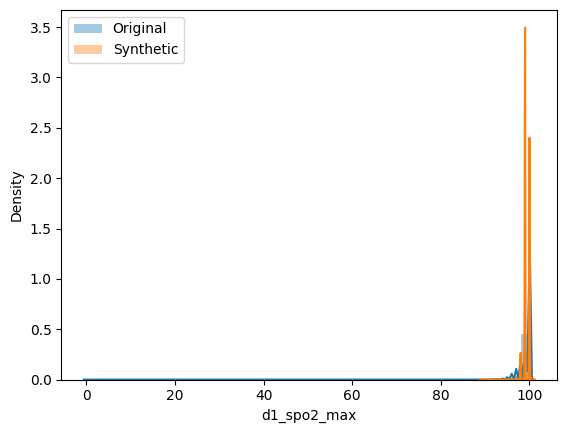

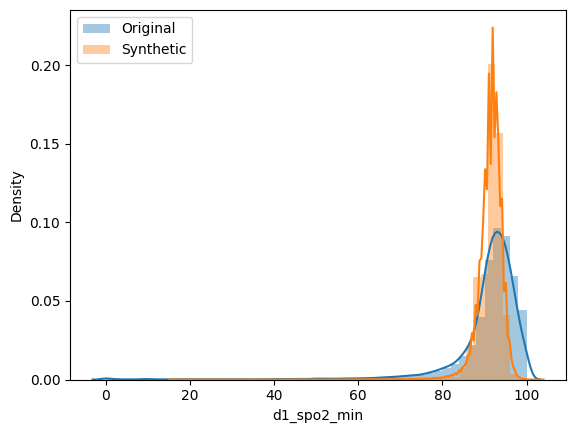

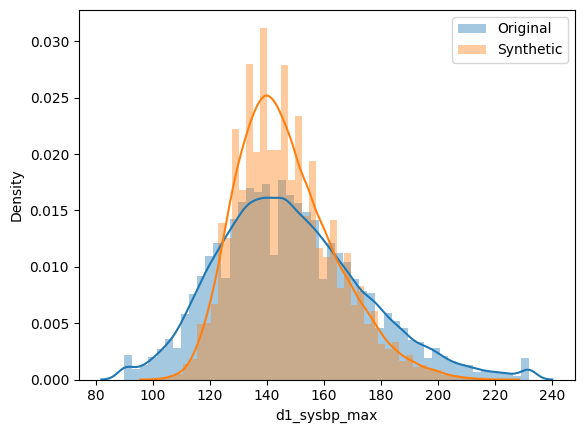

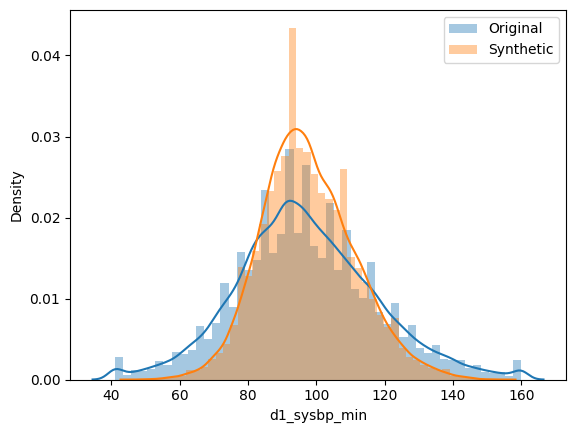

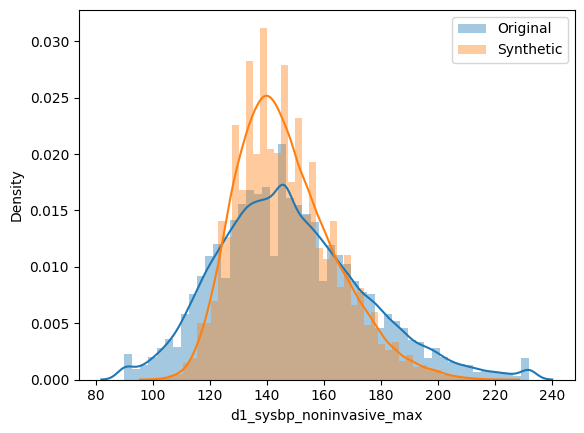

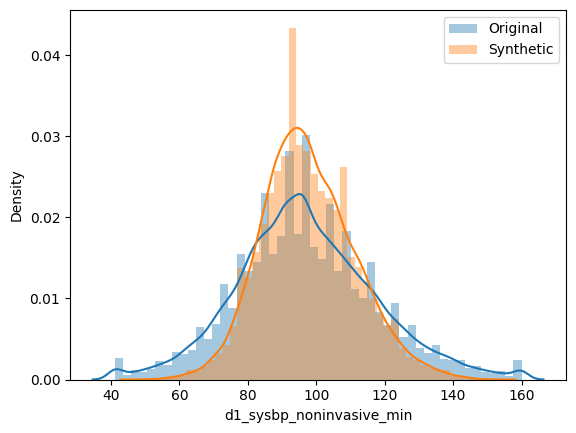

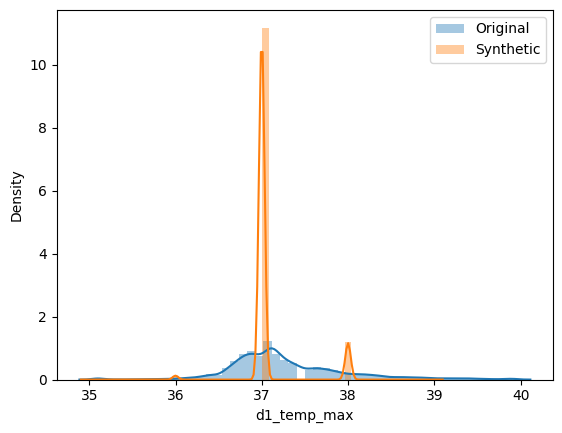

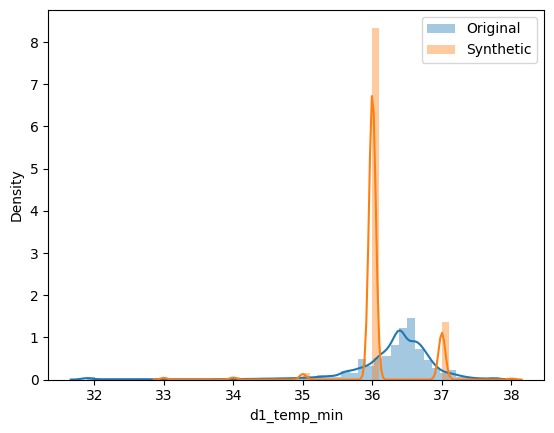

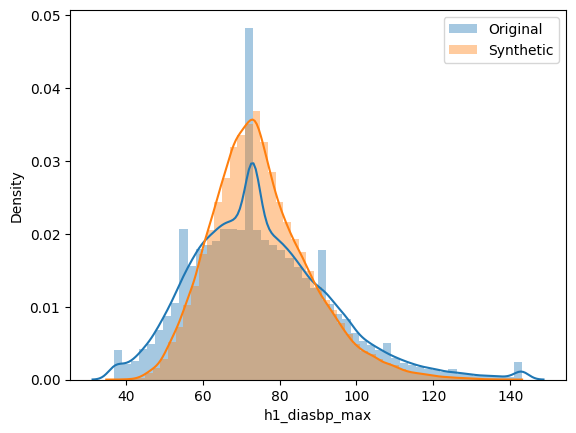

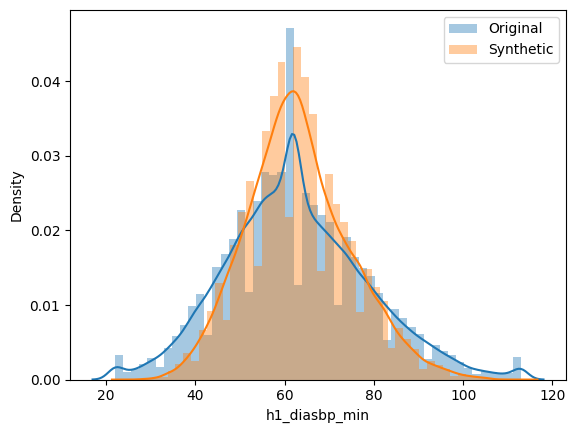

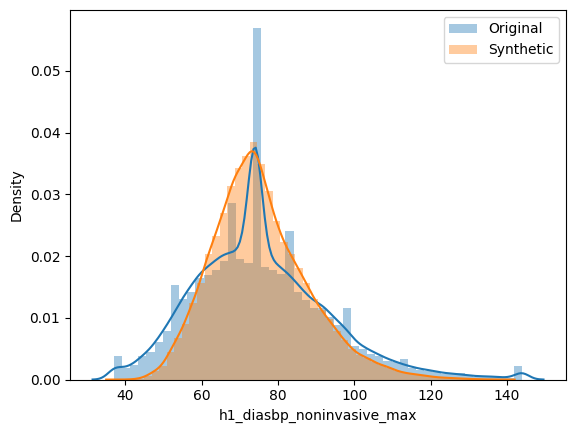

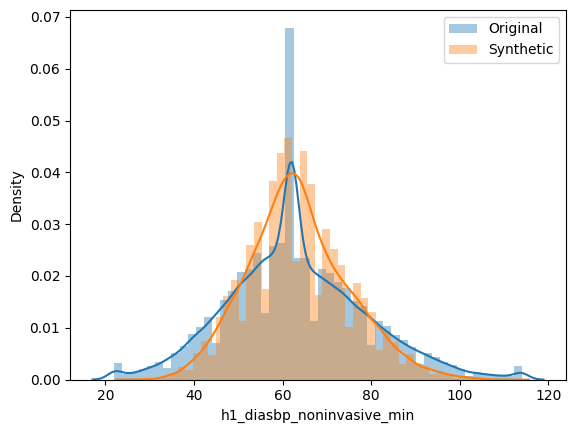

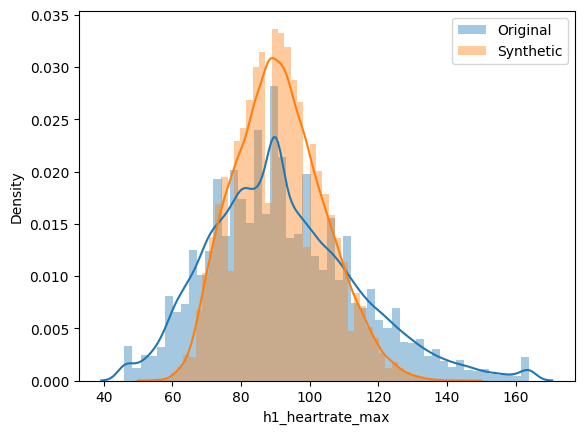

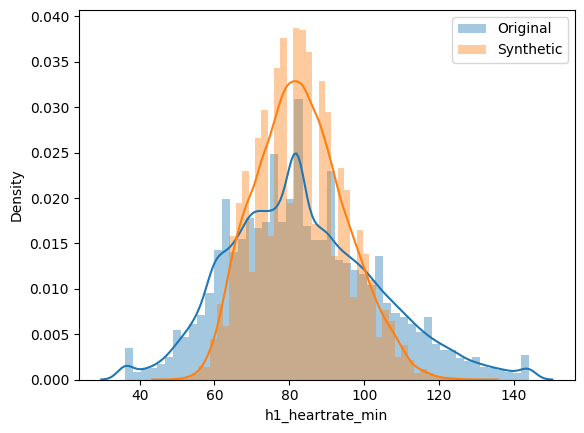

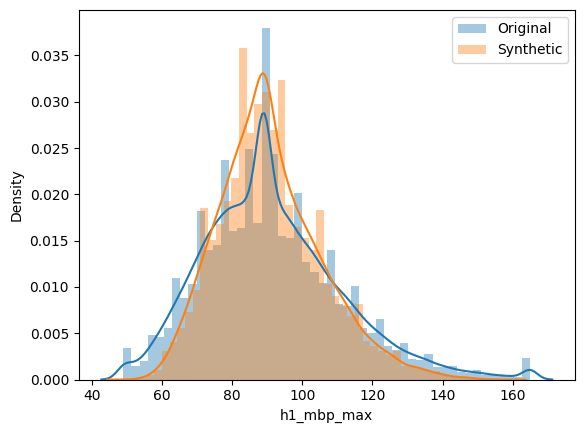

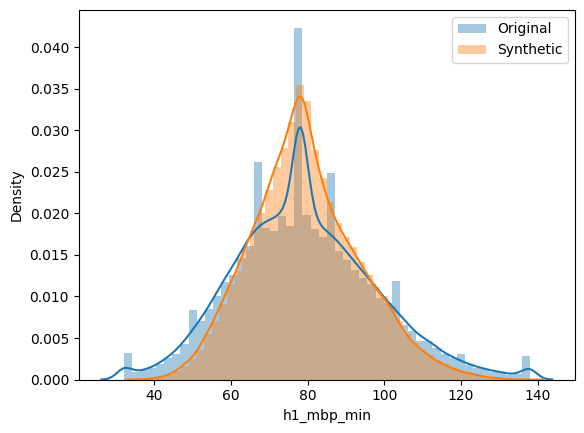

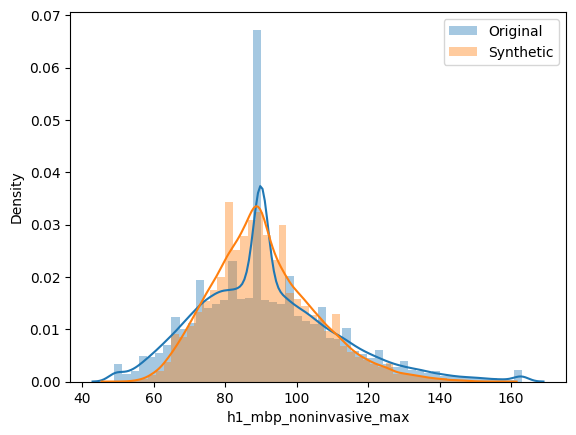

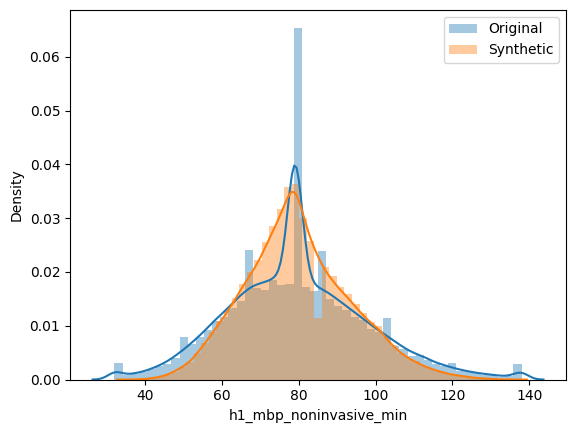

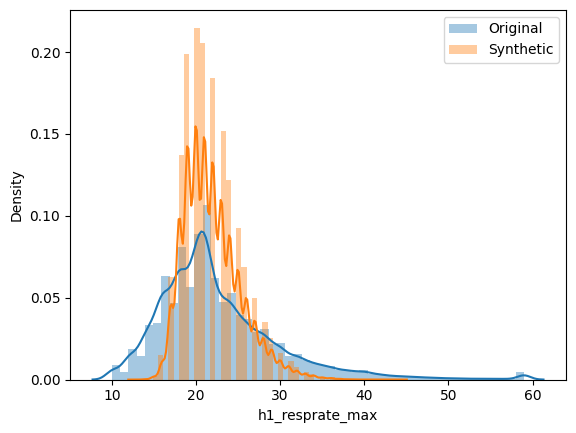

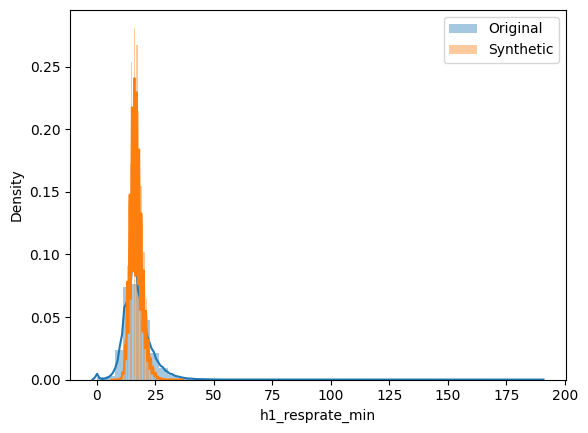

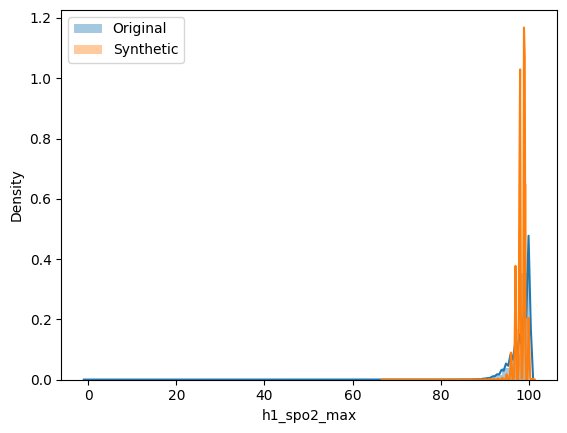

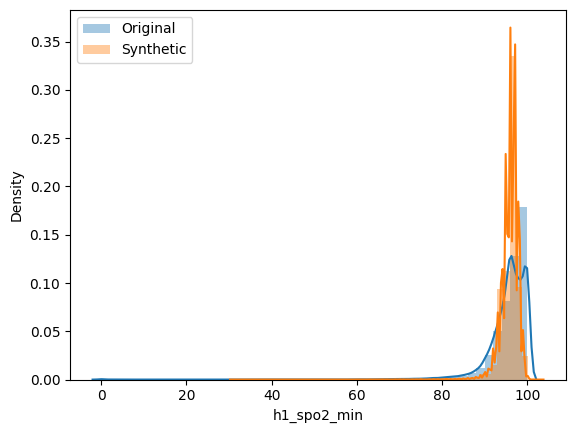

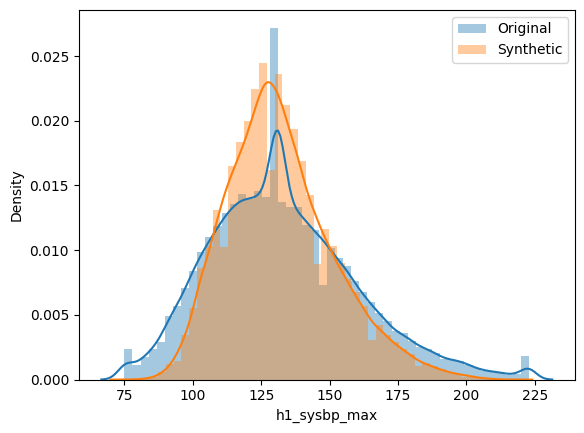

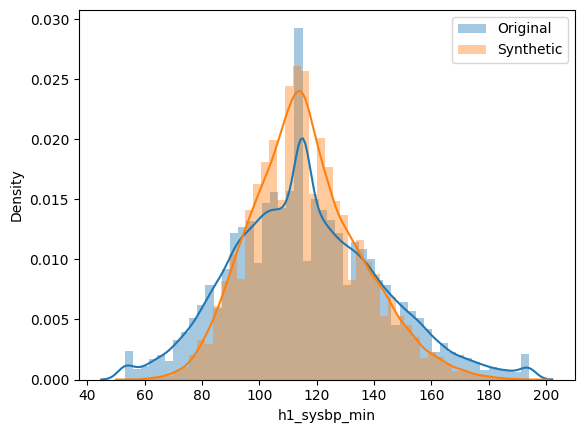

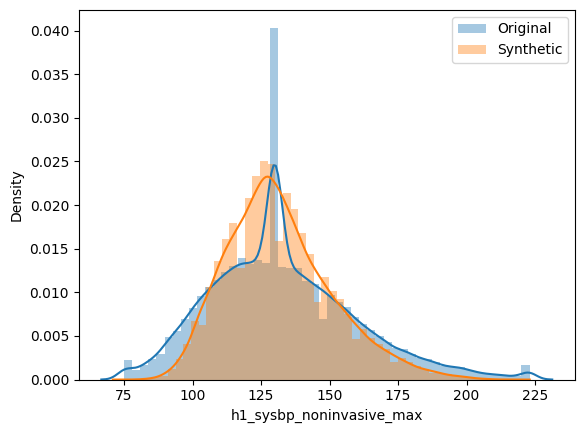

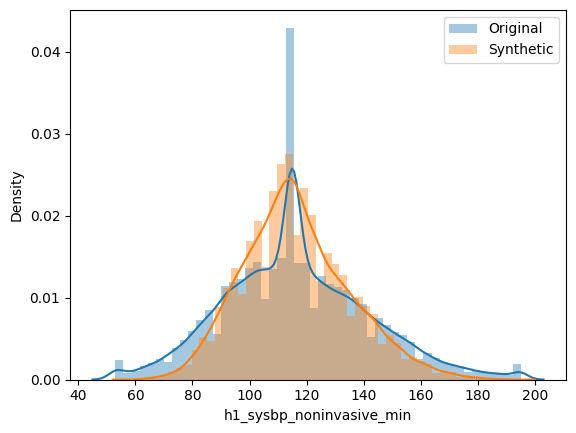

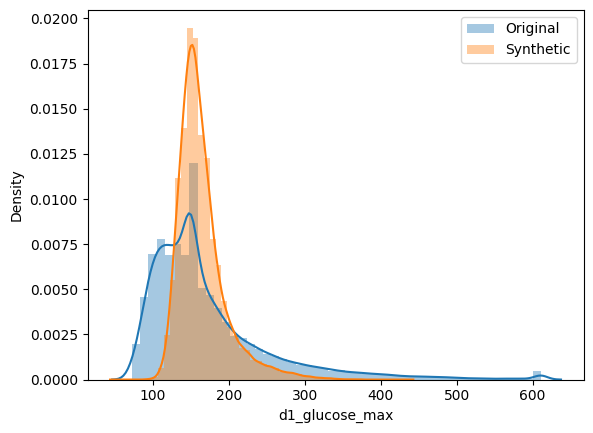

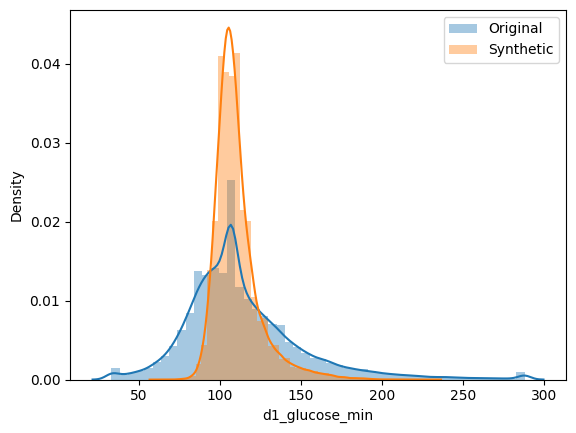

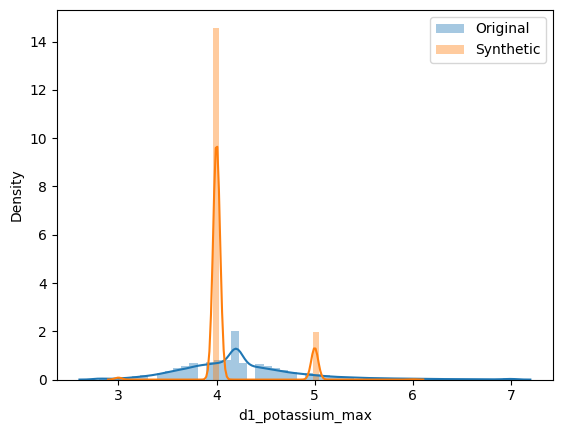

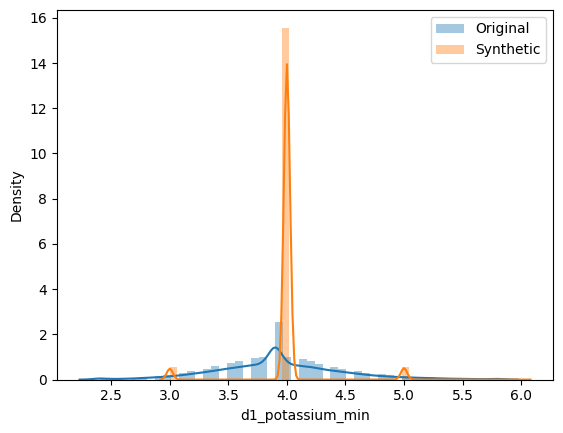

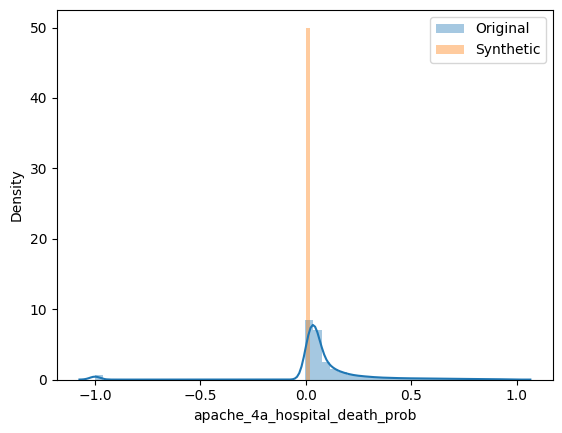

In [101]:
import warnings

# Ignoring warnnings
warnings.filterwarnings("ignore")

for col in df_imputed.columns:
    plt.figure()
    sns.distplot(df_imputed[col], label='Original')
    sns.distplot(df_avatarized1[col], label='Synthetic')
    plt.legend()

# Diminution in the preservation of the statistical value

We can observe that the distributions of the different variables do not overlap as well as with a lower value for 'k'. Therefore, we conclude that a higher value for 'k' leads to a decrease in the statistical value in synthetic data.


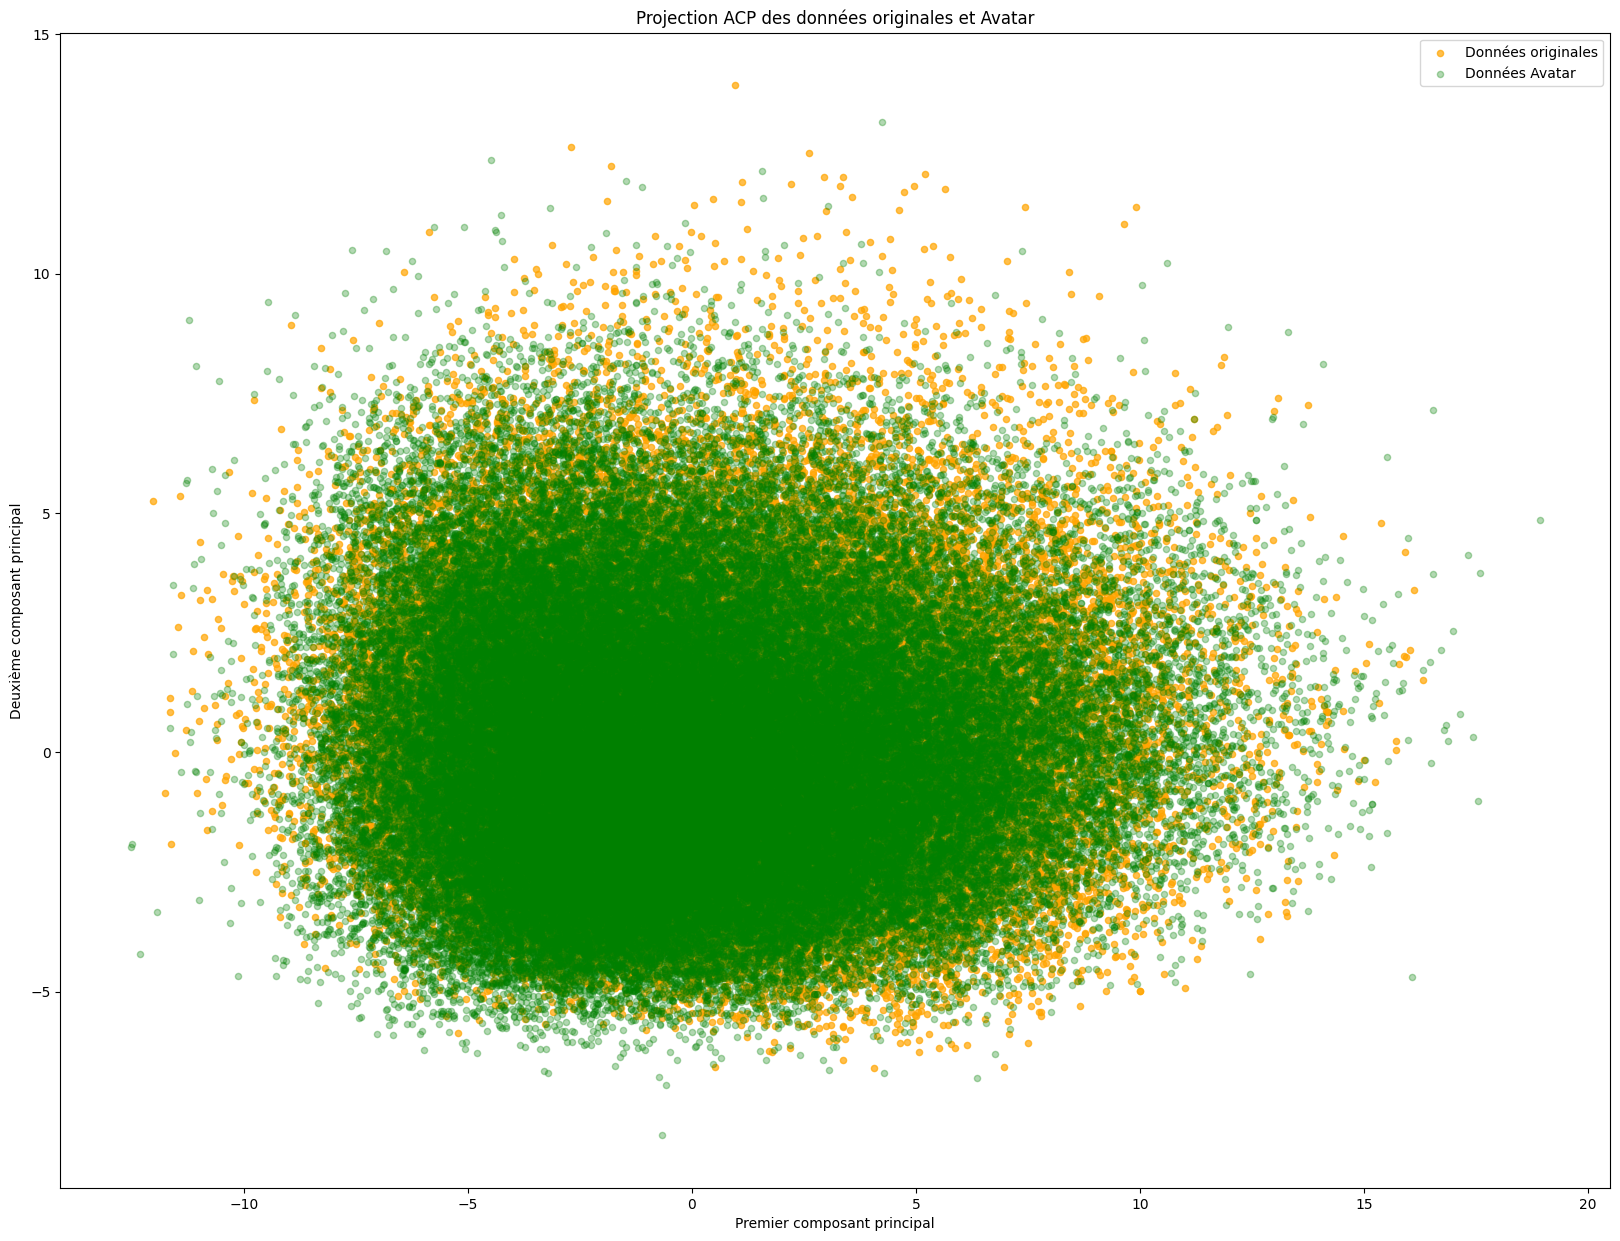

In [102]:
plotPca(df_imputed,df_avatarized1)

# Improvement in privacy

We have a higher values for DCR and NNDR which means that we have a better privacy with a high k.


In [103]:
DCR(df_imputed,df_avatarized1)

the value of DCR is 3.597223246997097
       Plus proche voisin  Distance
0                   12097  3.601691
1                   42559  3.350051
2                   73730  3.345458
3                   69504  3.099004
4                   39617  3.419608
...                   ...       ...
82537               38460  3.667471
82538                6986  3.060724
82539               32361  3.329724
82540               72655  4.394709
82541               38824  3.455870

[82542 rows x 2 columns]


(None, None)

In [104]:
NNDR(df_imputed,df_avatarized1)

the value of NNDR is 0    0.955582
dtype: float64


(None,
               0
 0      0.977088
 1      0.882586
 2      0.982405
 3      0.965368
 4      0.977168
 ...         ...
 82537  0.937713
 82538  0.925951
 82539  0.996043
 82540  0.981721
 82541  0.887799
 
 [82542 rows x 1 columns])

# Conclusion

Balancing Utility and Privacy

The compromise between utility and privacy is inherent in the nature of avatar data. While avatar data may not precisely replicate the original dataset, its utility can be impacted. However, anonymization techniques can be tailored to optimize utility preservation.

The choice of the value of 'k' should be made based on the specific situation in which the data will be used, as well as the sensitivity of the processed data and its intended purpose.